In [ ]:

#mount drive
from google.colab import drive
drive.mount('/content/MyDrive')
import seaborn as sns
sns.set_theme("paper")

Mounted at /content/MyDrive


In [ ]:
# @title Initialize Config

import torch
class Config:
    def __init__(self, **kwargs):
        self.batch_size = kwargs.get('batch_size', 64)
        self.epochs = kwargs.get('epochs', 50)
        self.lr = kwargs.get('lr', 0.001)
        self.input_format = kwargs.get('input_format', 'csv')
        self.channels_imu_acc = kwargs.get('channels_imu_acc', [])
        self.channels_imu_acc_test = kwargs.get('channels_imu_acc_test', [])
        self.channels_imu_gyr_test = kwargs.get('channels_imu_gyr_test', [])
        self.channels_imu_gyr = kwargs.get('channels_imu_gyr', [])
        self.channels_joints = kwargs.get('channels_joints', [])
        self.channels_emg = kwargs.get('channels_emg', [])
        self.seed = kwargs.get('seed', 42)
        self.data_folder_name = kwargs.get('data_folder_name', 'default_data_folder_name')
        self.dataset_root = kwargs.get('dataset_root', 'default_dataset_root')
        self.dataset_train_name = kwargs.get('dataset_train_name', 'train')
        self.dataset_test_name = kwargs.get('dataset_test_name', 'test')
        self.window_length = kwargs.get('window_length', 100)
        self.window_overlap = kwargs.get('window_overlap', 0)
        self.imu_transforms = kwargs.get('imu_transforms', [])
        self.joint_transforms = kwargs.get('joint_transforms', [])
        self.emg_transforms = kwargs.get('emg_transforms', [])
        self.input_format = kwargs.get('input_format', 'csv')
        self.train_subjects = kwargs.get('train_subjects', [])
        self.test_subjects = kwargs.get('test_subjects', [])

        self.dataset_name = self.generate_dataset_name()

    def generate_dataset_name(self):
        name = f"dataset_wl{self.window_length}_ol{self.window_overlap}_train{self.train_subjects}_test{self.test_subjects}"
        return name

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config(
    data_folder_name='/content/MyDrive/MyDrive/sd_datacollection',
    dataset_root='/content/datasets',
    dataset_train_name='train',
    dataset_test_name='test',
    batch_size=64,
    epochs=150,
    lr=0.001,
    window_length=100,
    window_overlap=75,
    input_format="csv",
    channels_imu_acc=['ACCX1', 'ACCY1', 'ACCZ1', 'ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_acc_test=['ACCX1', 'ACCY1', 'ACCZ1', 'ACCX2', 'ACCY2', 'ACCZ2', 'ACCX3', 'ACCY3', 'ACCZ3', 'ACCX4', 'ACCY4', 'ACCZ4', 'ACCX5', 'ACCY5', 'ACCZ5', 'ACCX6', 'ACCY6', 'ACCZ6'],
    channels_imu_gyr=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_imu_gyr_test=['GYROX1', 'GYROY1', 'GYROZ1', 'GYROX2', 'GYROY2', 'GYROZ2', 'GYROX3', 'GYROY3', 'GYROZ3', 'GYROX4', 'GYROY4', 'GYROZ4', 'GYROX5', 'GYROY5', 'GYROZ5', 'GYROX6', 'GYROY6', 'GYROZ6'],
    channels_joints=['elbow_flex_r', 'arm_flex_r', 'arm_add_r'],
    channels_emg=['IM EMG4', 'IM EMG5', 'IM EMG6'],
    train_subjects=['subject_2','subject_3','subject_4','subject_6','subject_7','subject_8', 'subject_9','subject_10', 'subject_11','subject_12','subject_13'],
    test_subjects=['subject_1']
)

In [ ]:
# @title Pre Window and save for reuse
import os
import shutil
import numpy as np
import pandas as pd

#import twdm for collab
from tqdm.notebook import tqdm


class DataSharder:
    def __init__(self, config, save_h5=False):
        self.config = config
        self.input_format = config.input_format
        self.data_folder_path = config.data_folder_name
        self.window_length = int(config.window_length)
        self.window_overlap = int(config.window_overlap)
        self.save_h5 = save_h5

    def load_data(self):
        print(f"Training subjects: {self.config.train_subjects}")
        print(f"Testing subjects: {self.config.test_subjects}")

        if self.input_format == 'csv':
            self._process_and_save_patients_csv(self.config.train_subjects, "train")
            self._process_and_save_patients_csv(self.config.test_subjects, "test")
        else:
            raise ValueError(f"Unsupported input format: {self.input_format}")

    def _resample_data(self, data, sample_rate):
        if sample_rate != self.sample_rate:
            data = torch.nn.functional.interpolate(data.unsqueeze(0), size=self.sample_rate, mode='linear').squeeze(0)
        return data

    def _process_and_save_patients_csv(self, patient_id_list, split):
        column_names = None
        for patient_id in tqdm(patient_id_list, desc=f"Processing {split} patients"):
            combined_path = os.path.join(self.data_folder_path, patient_id, "combined")
            if not os.path.exists(combined_path):
                print(f"Directory {combined_path} does not exist. Skipping patient {patient_id}.")
                continue

            patient_files = os.listdir(combined_path)
            for session_file in tqdm(patient_files, desc=f"Processing sessions for {patient_id}", leave=False):
                data = pd.read_csv(os.path.join(combined_path, session_file))
                if column_names is None:
                    column_names = data.columns.tolist()  # Convert Index to list
                data_np = data.to_numpy()
                # Pad array to fit columns if necessary
                if data_np.shape[1] < len(column_names):
                    data_np = np.pad(data_np, ((0, 0), (0, len(column_names) - data_np.shape[1])), mode='constant')
                elif data_np.shape[1] > len(column_names):
                    # Extend column names to match the data shape
                    extra_columns = [f"extra_{i}" for i in range(data_np.shape[1] - len(column_names))]
                    column_names.extend(extra_columns)

                self._save_windowed_data(pd.DataFrame(data_np, columns=column_names), patient_id, session_file.split('.')[0], split, is_csv=True)

    def _save_windowed_data(self, data, patient_id, session_id, split, is_csv=False):
        dataset_folder = os.path.join(self.config.dataset_root, self.config.dataset_name, self.config.dataset_train_name if split == "train" else self.config.dataset_test_name)
        os.makedirs(dataset_folder, exist_ok=True)

        window_size = self.window_length
        overlap = self.window_overlap
        step_size = window_size - overlap

        data_info_list = []

        for i in tqdm(range(0, len(data) - window_size + 1, step_size), desc=f"Windowing data for {patient_id}_{session_id}", leave=False):
            windowed_data = data.iloc[i:i+window_size] if is_csv else data[i:i+window_size]
            if windowed_data.shape[0] < window_size:
                continue

            windowed_data_np = windowed_data.to_numpy() if is_csv else windowed_data.cpu().numpy()

            file_name = f"{patient_id}_session_{session_id}_window_{i}_ws{window_size}_ol{overlap}.csv"
            file_path = os.path.join(dataset_folder, file_name)
            pd.DataFrame(windowed_data_np, columns=data.columns if is_csv else None).to_csv(file_path, index=False)
            data_info_list.append({"file_name": file_name, "file_path": file_path})

        data_info_df = pd.DataFrame(data_info_list)
        data_info_df.to_csv(os.path.join(self.config.dataset_root, self.config.dataset_name, f"{split}_info.csv"), index=False, mode='a', header=not os.path.exists(os.path.join(self.config.dataset_root, self.config.dataset_name, f"{split}_info.csv")))



reshard = True

if reshard:

  data_sharder = DataSharder(config)
  data_sharder.load_data()

  #copy new dataset to drive
  # shutil.copytree(os.path.join("/content/datasets",config.dataset_name),os.path.join("/content/MyDrive/MyDrive/datasets",config.dataset_name))

if not os.path.exists("/content/datasets"):
    #copy over
    shutil.copytree(os.path.join("/content/MyDrive/MyDrive/datasets",config.dataset_name),os.path.join("/content/datasets",config.dataset_name))


Training subjects: ['subject_2', 'subject_3', 'subject_4', 'subject_6', 'subject_7', 'subject_8', 'subject_9', 'subject_10', 'subject_11', 'subject_12', 'subject_13']
Testing subjects: ['subject_1']


Processing train patients:   0%|          | 0/11 [00:00<?, ?it/s]

Processing sessions for subject_2:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_armSwing_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_armSwing_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_armSwing_veryfast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_overheadreach_max_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_overheadreach_90_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_overheadreach_45_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elboxflexion_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elbowrotation_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elboxflexion_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elboxflexion_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_crossbody_slow_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_crossbody_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elbowrotation_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_armSwing_slow_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_crossbody_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_2_P002_T001_elbowrotation_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Processing sessions for subject_3:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_overheadreach45_combined:   0%|          | 0/126 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_overheadreach90_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_elbowflexion_fast_combined:   0%|          | 0/124 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_elbowflexion_normal_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_elbowflexion_slow_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T002_elbowrotation_slow_combined:   0%|          | 0/129 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_elbowrotation_fast_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_armswing_normal_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_armswing_veryfast_combined:   0%|          | 0/128 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_armswing_fast_combined:   0%|          | 0/129 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_elbowrotation_normal_combined:   0%|          | 0/78 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T003_armswing_slow_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_crossbody_normal_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_crossbody_fast_combined:   0%|          | 0/128 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_overheadreachMax_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_3_P003_T001_crossbody_slow_combined:   0%|          | 0/124 [00:00<?, ?it/s]

Processing sessions for subject_4:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_armSwing_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_armSwing_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_armSwing_veryfast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_armSwing_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_overheadreach_45_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_elbowrotation_slow_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_crossbody_slow_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_crossbody_fast_combined:   0%|          | 0/142 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_elbowflexion_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_overheadreach_90_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_elbowrotation_fast_combined:   0%|          | 0/140 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_crossbody_normal_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_elbowrotation_normal_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_overheadreach_max_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_elbowflexion_fast_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_4_P004_T001_elbowflexion_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Processing sessions for subject_6:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_armSwing_slow_combined:   0%|          | 0/112 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_armSwing_veryfast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_armSwing_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_overheadreach_max_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_armSwing_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T002_overheadreach_45_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_elbowflexion_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_elbowflexion_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_elbowflexion_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T002_crossbody_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T002_crossbody_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_elbowrotation_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T002_crossbody_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_elbowrotation_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_overheadreach_90_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_6_P006_T001_elbowrotation_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Processing sessions for subject_7:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T002_armSwing_slow_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_armSwing_veryfast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_overheadreach_max_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_overheadreach_90_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_elbowflexion_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_elbowflexion_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_elbowflexion_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_elbowrotation_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_elbowrotation_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_elbowrotation_normal_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_overheadreach_45_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_crossbody_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_crossbody_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_crossbody_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_armSwing_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_7_P007_T001_armSwing_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Processing sessions for subject_8:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_elbowflexion_fast_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_elbowrotation_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_armSwing_veryfast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_overheadreach_max_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_overheadreach_45_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_armSwing_fast_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_overheadreach_90_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_elbowflexion_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_crossbody_fast_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_elbowrotation_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_armSwing_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_armSwing_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_elbowflexion_normal_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_crossbody_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_crossbody_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_8_P008_T001_elbowrotation_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Processing sessions for subject_9:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_armswing_normal_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_armswing_slow_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_elbowflexion_normal_combined:   0%|          | 0/127 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_armswing_fast_combined:   0%|          | 0/124 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_overheadreach_90_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_armswing_veryfast_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_elbowflexion_slow_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_overheadreach_max_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T002_elbowrotation_fast_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T001_overheadreach_45_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T002_elbowflexion_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T002_crossbody_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T002_crossbody_normal_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T002_elbowrotation_slow_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T002_elbowrotation_normal_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_9_P009_T002_crossbody_fast_combined:   0%|          | 0/124 [00:00<?, ?it/s]

Processing sessions for subject_10:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_overheadreach_45_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_armSwing_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_elbowflexion_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_elbowflexion_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_overheadreach_90_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T002_elbowrotation_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T002_elbowrotation_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_armSwing_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_crossbody_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_armSwing_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_crossbody_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_overheadreach_max_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_crossbody_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T002_elbowrotation_normal_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_armSwing_veryfast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_10_P010_T001_elbowflexion_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Processing sessions for subject_11:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_overheadreach_90_combined:   0%|          | 0/124 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_overheadreach_max_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_armSwing_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_armSwing_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_armSwing_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_crossbody_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_elbowflexion_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_crossbody_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_crossbody_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_elbowflexion_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_elbowrotation_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_overheadreach_45_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_armSwing_veryfast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_elbowrotation_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_elbowrotation_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_11_P011_T001_elbowflexion_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Processing sessions for subject_12:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_armSwing_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_elbowrotation_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s…

Windowing data for subject_12_P0012_T001_crossbody_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_armSwing_slow_combined:   0%|          | 0/126 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_overheadreach_90_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_armSwing_veryfast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_armSwing_fast_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_overheadreach_45_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_elbowflexion_slow_combined:   0%|          | 0/128 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_elbowrotation_fast_combined:   0%|          | 0/129 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_elbowrotation_slow_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_elbowflexion_normal_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_overheadreach_max_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_crossbody_fast_combined:   0%|          | 0/124 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_elbowflexion_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_12_P0012_T001_crossbody_slow_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Processing sessions for subject_13:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_overheadreach_max_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_armswing_veryfast_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_crossbody_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_crossbody_normal_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_overheadreach_90_combined:   0%|          | 0/119 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_elbowrotation_slow_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_elbowflexion_slow_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_armswing_slow_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_elbowrotation_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_crossbody_fast_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_elbowflexion_fast_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_overheadreach_45_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_elbowrotation_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_armswing_fast_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_elbowflexion_normal_combined:   0%|          | 0/120 [00:00<?, ?it/s]

Windowing data for subject_13_p13_t001_armswing_normal_combined:   0%|          | 0/121 [00:00<?, ?it/s]

Processing test patients:   0%|          | 0/1 [00:00<?, ?it/s]

Processing sessions for subject_1:   0%|          | 0/16 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_crossbody_fast_combined:   0%|          | 0/130 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_elbowrotation_fast_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_elbowflexion_fast_combined:   0%|          | 0/124 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_armSwing_fast_combined:   0%|          | 0/126 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_armSwing_veryfast_combined:   0%|          | 0/123 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_overheadreach_max_combined:   0%|          | 0/130 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_armSwing_normal_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_elbowflexion_slow_combined:   0%|          | 0/128 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_overheadreach_90_combined:   0%|          | 0/130 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_armSwing_slow_combined:   0%|          | 0/122 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_elbowrotation_normal_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_elbowrotation_slow_combined:   0%|          | 0/131 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_overheadreach_45_combined:   0%|          | 0/125 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_elbowflexion_normal_combined:   0%|          | 0/127 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_crossbody_normal_combined:   0%|          | 0/131 [00:00<?, ?it/s]

Windowing data for subject_1_P001_T001_crossbody_slow_combined:   0%|          | 0/129 [00:00<?, ?it/s]

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ImuJointPairDataset(Dataset):
    def __init__(self, config, split='train'):
        self.config = config
        self.split = split
        self.input_format = config.input_format
        self.channels_imu_acc = config.channels_imu_acc
        self.channels_imu_acc_test = config.channels_imu_acc_test
        self.channels_imu_gyr = config.channels_imu_gyr
        self.channels_imu_gyr_test = config.channels_imu_gyr_test
        self.channels_joints = config.channels_joints
        self.channels_emg = config.channels_emg

        dataset_name = self.config.dataset_name
        self.root_dir_train = os.path.join(self.config.dataset_root, dataset_name, self.config.dataset_train_name)
        self.root_dir_test = os.path.join(self.config.dataset_root, dataset_name, self.config.dataset_test_name)

        train_info_path = os.path.join(self.config.dataset_root, dataset_name, "train_info.csv")
        test_info_path = os.path.join(self.config.dataset_root, dataset_name, "test_info.csv")
        self.data = pd.read_csv(train_info_path) if split == 'train' else pd.read_csv(test_info_path)



    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if self.split == "train":
            file_path = os.path.join(self.root_dir_train, self.data.iloc[idx, 0])
        else:
            file_path = os.path.join(self.root_dir_test, self.data.iloc[idx, 0])


        if self.input_format == "csv":
            combined_data = pd.read_csv(file_path)
        else:
            raise ValueError("Unsupported input format: {}".format(self.input_format))

        imu_data_acc, imu_data_gyr, joint_data, emg_data = self._extract_and_transform(combined_data)
        windows = self._apply_windowing(imu_data_acc, imu_data_gyr, joint_data, emg_data, self.config.window_length, self.config.window_overlap)

        acc_concat = np.concatenate([w[0] for w in windows], axis=0)
        gyr_concat = np.concatenate([w[1] for w in windows], axis=0)
        joint_concat = np.concatenate([w[2] for w in windows], axis=0)
        emg_concat = np.concatenate([w[3] for w in windows], axis=0)

        return acc_concat, gyr_concat, joint_concat, emg_concat

    def _extract_and_transform(self, combined_data):
        imu_data_acc = self._extract_channels(combined_data, self.channels_imu_acc)
        imu_data_gyr = self._extract_channels(combined_data, self.channels_imu_gyr)
        joint_data = self._extract_channels(combined_data, self.channels_joints)
        emg_data = self._extract_channels(combined_data, self.channels_emg)

        combined_data = np.concatenate([imu_data_acc, imu_data_gyr, joint_data, emg_data], axis=1)
        scaled_data = combined_data

        imu_data_acc = scaled_data[:, :imu_data_acc.shape[1]]
        imu_data_gyr = scaled_data[:, imu_data_acc.shape[1]:imu_data_acc.shape[1] + imu_data_gyr.shape[1]]
        joint_data = scaled_data[:, imu_data_acc.shape[1] + imu_data_gyr.shape[1]:imu_data_acc.shape[1] + imu_data_gyr.shape[1] + joint_data.shape[1]]
        emg_data = scaled_data[:, imu_data_acc.shape[1] + imu_data_gyr.shape[1] + joint_data.shape[1]:]

        imu_data_acc = self.apply_transforms(imu_data_acc, self.config.imu_transforms)
        imu_data_gyr = self.apply_transforms(imu_data_gyr, self.config.imu_transforms)
        joint_data = self.apply_transforms(joint_data, self.config.joint_transforms)
        emg_data = self.apply_transforms(emg_data, self.config.emg_transforms)

        return imu_data_acc, imu_data_gyr, joint_data, emg_data

    def _extract_channels(self, combined_data, channels):
        if isinstance(channels, slice):
            return combined_data.iloc[:, channels].values if self.input_format == "csv" else combined_data[:, channels]
        else:
            return combined_data[channels].values if self.input_format == "csv" else combined_data[:, channels]

    def _apply_windowing(self, imu_data_acc, imu_data_gyr, joint_data, emg_data, window_length, window_overlap):
        num_samples = imu_data_acc.shape[0]
        step = window_length - window_overlap
        windows = []

        for start in range(0, num_samples - window_length + 1, step):
            end = start + window_length
            window = (
                imu_data_acc[start:end],
                imu_data_gyr[start:end],
                joint_data[start:end],
                emg_data[start:end]
            )
            windows.append(window)

        return windows

    def apply_transforms(self, data, transforms):
        for transform in transforms:
            data = transform(data)
        data = torch.tensor(data, dtype=torch.float32)
        return data


# Create datasets
train_dataset = ImuJointPairDataset(config, split='train')
test_dataset = ImuJointPairDataset(config, split='test')

# Setup validation dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(0.9 * len(train_dataset)), len(train_dataset) - int(0.9 * len(train_dataset))])

# Setup dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

acc,gyro,target,emg=next(iter(train_loader))
print(acc.shape)
print(gyro.shape)
print(target.shape)
print(emg.shape)

torch.Size([64, 100, 18])
torch.Size([64, 100, 18])
torch.Size([64, 100, 3])
torch.Size([64, 100, 3])


Plotting KDE for raw and normalized EMG data (Z-score normalized)...


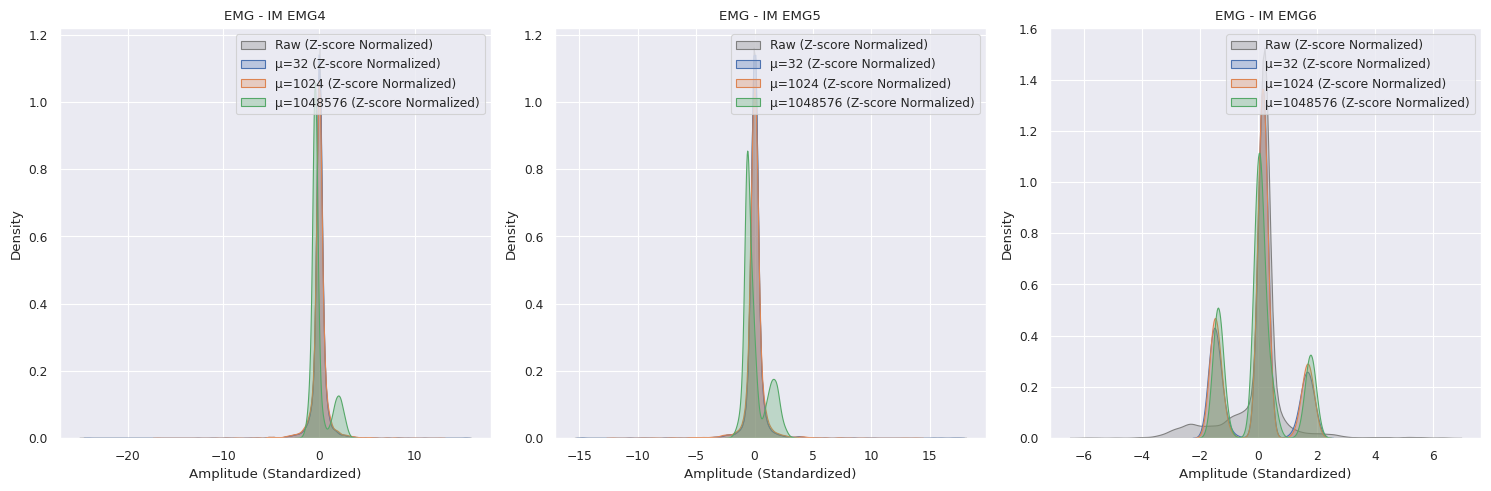

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def z_score_normalization(data):
    """Apply z-score normalization to standardize the data."""
    mean = np.mean(data, axis=(0, 1), keepdims=True)
    std = np.std(data, axis=(0, 1), keepdims=True)
    return (data - mean) / std

def plot_kde_comparison(data_list, raw_data, label, mu_values, channel_names=None):
    """Plot KDE for raw and μ-law normalized data."""
    channels = raw_data.shape[2]  # Get number of channels from the third axis (axis 2)

    # Standardize both raw and μ-law normalized data using z-score normalization
    raw_flat = z_score_normalization(raw_data).reshape(-1, channels)  # Standardize and flatten raw data
    data_flat = [z_score_normalization(data).reshape(-1, channels) for data in data_list]  # Standardize and flatten normalized data

    # Define grid size based on the number of channels (1 row for 3 channels)
    rows = (channels + 2) // 3  # Adjust number of rows based on the number of channels
    fig, axs = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axs = axs.ravel()  # Flatten the axis array for easy indexing

    for i in range(channels):
        # Plot KDE for raw data with transparency
        sns.kdeplot(raw_flat[:, i], ax=axs[i], label='Raw (Z-score Normalized)', color='gray', fill=True, alpha=0.3)

        # Plot KDE for μ-law normalized data for different μ values with transparency
        for j, data in enumerate(data_flat):
            sns.kdeplot(data[:, i], ax=axs[i], label=f'μ={mu_values[j]} (Z-score Normalized)', fill=True, alpha=0.3)

        axs[i].set_title(f'{label} - {channel_names[i]}' if channel_names else f'{label} - Channel {i}')
        axs[i].set_xlabel('Amplitude (Standardized)')
        axs[i].set_ylabel('Density')
        axs[i].legend()

    plt.tight_layout()
    plt.show()

def mu_law_normalization(x, mu=2**20):
    """Applies μ-law normalization to the input."""
    return np.sign(x) * np.log(1 + mu * np.abs(x)) / np.log(1 + mu)

# List to store normalized data for comparison
mu_values = [2**5,2**10,2**20]

# Normalize EMG data with different μ values
normalized_emg_list = [mu_law_normalization(emg.numpy(), mu=mu) for mu in mu_values]

# Plot KDE for raw and μ-law normalized EMG data across the entire dataset using z-score normalization
print("Plotting KDE for raw and normalized EMG data (Z-score normalized)...")
plot_kde_comparison(normalized_emg_list, emg.numpy(), label="EMG", mu_values=mu_values, channel_names=config.channels_emg)


In [ ]:
# @title Remake but with mu-noramlization
config.emg_transforms = [lambda x: mu_law_normalization(x, mu=mu) for mu in mu_values]

# Create datasets
train_dataset = ImuJointPairDataset(config, split='train')
test_dataset = ImuJointPairDataset(config, split='test')

# Setup validation dataset
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [int(0.9 * len(train_dataset)), len(train_dataset) - int(0.9 * len(train_dataset))])

# Setup dataloaders
train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

acc,gyro,target,emg=next(iter(train_loader))
print(acc.shape)
print(gyro.shape)
print(target.shape)
print(emg.shape)

torch.Size([64, 100, 18])
torch.Size([64, 100, 18])
torch.Size([64, 100, 3])
torch.Size([64, 100, 3])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
from scipy.signal import butter, filtfilt
from sklearn.metrics import mean_squared_error
import numpy as np
class Encoder_1(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_1, self).__init__()
        self.lstm_1 = nn.LSTM(input_dim, 128, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.LSTM(256, 64, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2




class Encoder_2(nn.Module):
    def __init__(self, input_dim, dropout):
        super(Encoder_2, self).__init__()
        self.lstm_1 = nn.GRU(input_dim, 128, bidirectional=True, batch_first=True, dropout=0.0)
        self.lstm_2 = nn.GRU(256, 64, bidirectional=True, batch_first=True, dropout=0.0)
        self.flatten=nn.Flatten()
        self.fc = nn.Linear(128, 32)
        self.dropout_1=nn.Dropout(dropout)
        self.dropout_2=nn.Dropout(dropout)


    def forward(self, x):
        out_1, _ = self.lstm_1(x)
        out_1=self.dropout_1(out_1)
        out_2, _ = self.lstm_2(out_1)
        out_2=self.dropout_2(out_2)

        return out_2


class GatingModule(nn.Module):
    def __init__(self, input_size):
        super(GatingModule, self).__init__()
        self.gate = nn.Sequential(
            nn.Linear(2*input_size, input_size),
            nn.Sigmoid()
        )

    def forward(self, input1, input2):
        # Apply gating mechanism
        gate_output = self.gate(torch.cat((input1,input2),dim=-1))

        # Scale the inputs based on the gate output
        gated_input1 = input1 * gate_output
        gated_input2 = input2 * (1 - gate_output)

        # Combine the gated inputs
        output = gated_input1 + gated_input2
        return output
#variable w needs to be checked for correct value, stand-in value used
class teacher(nn.Module):
    def __init__(self, input_acc, input_gyr, input_emg, drop_prob=0.25, w=100):
        super(teacher, self).__init__()

        self.w=w
        self.encoder_1_acc=Encoder_1(input_acc, drop_prob)
        self.encoder_1_gyr=Encoder_1(input_gyr, drop_prob)
        self.encoder_1_emg=Encoder_1(input_emg, drop_prob)

        self.encoder_2_acc=Encoder_2(input_acc, drop_prob)
        self.encoder_2_gyr=Encoder_2(input_gyr, drop_prob)
        self.encoder_2_emg=Encoder_2(input_emg, drop_prob)

        self.BN_acc= nn.BatchNorm1d(input_acc, affine=False)
        self.BN_gyr= nn.BatchNorm1d(input_gyr, affine=False)
        self.BN_emg= nn.BatchNorm1d(input_emg, affine=False)


        self.fc = nn.Linear(2*3*128+128,3)
        self.dropout=nn.Dropout(p=0.05)

        self.gate_1=GatingModule(128)
        self.gate_2=GatingModule(128)
        self.gate_3=GatingModule(128)

        self.fc_kd = nn.Linear(3*128, 2*128)

               # Define the gating network
        self.weighted_feat = nn.Sequential(
            nn.Linear(128, 1),
            nn.Sigmoid())

        self.attention=nn.MultiheadAttention(3*128,4,batch_first=True)
        self.gating_net = nn.Sequential(nn.Linear(128*3, 3*128), nn.Sigmoid())
        self.gating_net_1 = nn.Sequential(nn.Linear(2*3*128+128, 2*3*128+128), nn.Sigmoid())

        self.pool = nn.MaxPool1d(kernel_size=2)


    def forward(self, x_acc, x_gyr, x_emg):

        x_acc_1=x_acc.view(x_acc.size(0)*x_acc.size(1),x_acc.size(-1))
        x_gyr_1=x_gyr.view(x_gyr.size(0)*x_gyr.size(1),x_gyr.size(-1))
        x_emg_1=x_emg.view(x_emg.size(0)*x_emg.size(1),x_emg.size(-1))

        x_acc_1=self.BN_acc(x_acc_1)
        x_gyr_1=self.BN_gyr(x_gyr_1)
        x_emg_1=self.BN_emg(x_emg_1)

        x_acc_2=x_acc_1.view(-1, self.w, x_acc_1.size(-1))
        x_gyr_2=x_gyr_1.view(-1, self.w, x_gyr_1.size(-1))
        x_emg_2=x_emg_1.view(-1, self.w, x_emg_1.size(-1))

        x_acc_1=self.encoder_1_acc(x_acc_2)
        x_gyr_1=self.encoder_1_gyr(x_gyr_2)
        x_emg_1=self.encoder_1_emg(x_emg_2)

        x_acc_2=self.encoder_2_acc(x_acc_2)
        x_gyr_2=self.encoder_2_gyr(x_gyr_2)
        x_emg_2=self.encoder_2_emg(x_emg_2)

        # x_acc=torch.cat((x_acc_1,x_acc_2),dim=-1)
        # x_gyr=torch.cat((x_gyr_1,x_gyr_2),dim=-1)
        # x_emg=torch.cat((x_emg_1,x_emg_2),dim=-1)

        x_acc=self.gate_1(x_acc_1,x_acc_2)
        x_gyr=self.gate_2(x_gyr_1,x_gyr_2)
        x_emg=self.gate_3(x_emg_1,x_emg_2)

        x=torch.cat((x_acc,x_gyr,x_emg),dim=-1)
        x_kd=self.fc_kd(x)


        out_1, attn_output_weights=self.attention(x,x,x)

        gating_weights = self.gating_net(x)
        out_2=gating_weights*x

        weights_1 = self.weighted_feat(x[:,:,0:128])
        weights_2 = self.weighted_feat(x[:,:,128:2*128])
        weights_3 = self.weighted_feat(x[:,:,2*128:3*128])
        x_1=weights_1*x[:,:,0:128]
        x_2=weights_2*x[:,:,128:2*128]
        x_3=weights_3*x[:,:,2*128:3*128]
        out_3=x_1+x_2+x_3

        out=torch.cat((out_1,out_2,out_3),dim=-1)

        gating_weights_1 = self.gating_net_1(out)
        out=gating_weights_1*out

        out=self.fc(out)

        #print(out.shape)
        return out,x_kd


class RMSELoss(nn.Module):
    def __init__(self):
        super(RMSELoss, self).__init__()
    def forward(self, output, target):
        loss = torch.sqrt(torch.mean((output - target) ** 2))
        return loss
#prediction function
def RMSE_prediction(yhat_4,test_y, output_dim,print_losses=True):

  s1=yhat_4.shape[0]*yhat_4.shape[1]

  test_o=test_y.reshape((s1,output_dim))
  yhat=yhat_4.reshape((s1,output_dim))




  y_1_no=yhat[:,0]
  y_2_no=yhat[:,1]
  y_3_no=yhat[:,2]

  y_1=y_1_no
  y_2=y_2_no
  y_3=y_3_no


  y_test_1=test_o[:,0]
  y_test_2=test_o[:,1]
  y_test_3=test_o[:,2]



  cutoff=6
  fs=200
  order=4

  nyq = 0.5 * fs
  ## filtering data ##
  def butter_lowpass_filter(data, cutoff, fs, order):
      normal_cutoff = cutoff / nyq
      # Get the filter coefficients
      b, a = butter(order, normal_cutoff, btype='low', analog=False)
      y = filtfilt(b, a, data)
      return y



  Z_1=y_1
  Z_2=y_2
  Z_3=y_3



  ###calculate RMSE

  rmse_1 =((np.sqrt(mean_squared_error(y_test_1,y_1))))
  rmse_2 =((np.sqrt(mean_squared_error(y_test_2,y_2))))
  rmse_3 =((np.sqrt(mean_squared_error(y_test_3,y_3))))





  p_1=np.corrcoef(y_1, y_test_1)[0, 1]
  p_2=np.corrcoef(y_2, y_test_2)[0, 1]
  p_3=np.corrcoef(y_3, y_test_3)[0, 1]




              ### Correlation ###
  p=np.array([p_1,p_2,p_3])
  #,p_4,p_5,p_6,p_7])




      #### Mean and standard deviation ####

  rmse=np.array([rmse_1,rmse_2,rmse_3])
  #,rmse_4,rmse_5,rmse_6,rmse_7])

      #### Mean and standard deviation ####
  m=statistics.mean(rmse)
  SD=statistics.stdev(rmse)


  m_c=statistics.mean(p)
  SD_c=statistics.stdev(p)


  if print_losses:
    print(rmse_1)
    print(rmse_2)
    print(rmse_3)
    print("\n")
    print(p_1)
    print(p_2)
    print(p_3)
    print('Mean: %.3f' % m,'+/- %.3f' %SD)
    print('Mean: %.3f' % m_c,'+/- %.3f' %SD_c)

  return rmse, p, Z_1,Z_2,Z_3
  #,Z_4,Z_5,Z_6,Z_7



############################################################################################################################################################################################################################################################################################################################################################################################################################################################################




In [ ]:
import torch
import numpy as np
import os
import time
from tqdm.notebook import tqdm

import statistics

# Define the GHM-MSE Loss
class GHMMSELoss(torch.nn.Module):
    def __init__(self, bins=10, momentum=0.75):
        super(GHMMSELoss, self).__init__()
        self.bins = bins
        self.momentum = momentum
        self.edges = torch.linspace(0, 1, bins + 1)  # Initially on CPU
        self.acc_sum = torch.zeros(bins)  # Initially on CPU

    def forward(self, input, target):
        device = input.device  # Ensure we use the same device as input tensor
        self.edges = self.edges.to(device)  # Move edges to the same device
        self.acc_sum = self.acc_sum.to(device)  # Move acc_sum to the same device

        # Calculate the gradient norm (g)
        g = torch.sigmoid(2 * (input - target))
        g = g.detach()

        # Compute the gradient density
        n = input.size(0)
        inds = torch.bucketize(g, self.edges)
        total = torch.zeros_like(self.acc_sum)

        # Counting in each bin and calculate gradient harmonizing parameter (beta)
        for i in range(self.bins):
            total[i] = (inds == i + 1).float().sum()

        if self.training:
            self.acc_sum = self.momentum * self.acc_sum + (1 - self.momentum) * total
        acc_sum = self.acc_sum.clone().detach()

        # Beta calculation based on GD
        beta = torch.zeros_like(inds, dtype=torch.float32)
        for i in range(self.bins):
            beta[inds == i + 1] = n / (acc_sum[i] + 1e-6)

        loss = (beta * (input - target) ** 2).mean()
        return loss


# Define OHEM-MSE Loss
class OHEMMSELoss(torch.nn.Module):
    def __init__(self, ratio=0.7):
        super(OHEMMSELoss, self).__init__()
        self.ratio = ratio
        self.mse_loss = torch.nn.MSELoss(reduction='none')

    def forward(self, input, target):
        losses = self.mse_loss(input, target)
        num_hard_examples = int(self.ratio * losses.numel())
        hard_losses, _ = torch.topk(losses.view(-1), num_hard_examples)
        return hard_losses.mean()

# Evaluation function
def evaluate_model(device, model, loader, criterion):
    """Runs evaluation on the validation or test set."""
    model.eval()
    total_loss = 0.0
    total_pcc = np.zeros(len(config.channels_joints))
    total_rmse = np.zeros(len(config.channels_joints))

    with torch.no_grad():
        for i, (data_acc, data_gyr, target, data_EMG) in enumerate(loader):
            output, _ = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())
            loss = criterion(output, target.to(device).float())
            batch_rmse, batch_pcc, _, _, _ = RMSE_prediction(output.detach().cpu().numpy(), target.detach().cpu().numpy(), len(config.channels_joints), print_losses=False)
            total_loss += loss.item()
            total_pcc += batch_pcc
            total_rmse += batch_rmse

    avg_loss = total_loss / len(loader)
    avg_pcc = total_pcc / len(loader)
    avg_rmse = total_rmse / len(loader)

    return avg_loss, avg_pcc, avg_rmse

# Save checkpoint function
def save_checkpoint(model, optimizer, epoch, filename, train_loss, val_loss, test_loss=None, channelwise_metrics=None):
    """Saves the model, optimizer state, and losses (including channel-wise) to a checkpoint."""
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_channelwise_metrics': channelwise_metrics['train'],
        'val_channelwise_metrics': channelwise_metrics['val'],
    }
    if test_loss is not None:
        checkpoint['test_loss'] = test_loss
        checkpoint['test_channelwise_metrics'] = channelwise_metrics['test']
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved for epoch {epoch + 1}")

# Training function
def train_teacher(device, train_loader, val_loader, test_loader, learn_rate, epochs, model, filename,loss_function):

    model.to(device)
    criterion = loss_function
    optimizer = torch.optim.Adam(model.parameters(), lr=learn_rate)

    train_losses = []
    val_losses = []
    test_losses = []

    train_pccs = []
    val_pccs = []
    test_pccs = []

    train_rmses = []
    val_rmses = []
    test_rmses = []

    start_time = time.time()
    best_val_loss = float('inf')
    patience = 10
    patience_counter = 0

    for epoch in range(epochs):
        epoch_start_time = time.time()
        model.train()

        epoch_train_loss = np.zeros(len(config.channels_joints))
        epoch_train_pcc = np.zeros(len(config.channels_joints))
        epoch_train_rmse = np.zeros(len(config.channels_joints))

        for i, (data_acc, data_gyr, target, data_EMG) in enumerate(tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} Training")):
            optimizer.zero_grad()
            output, _ = model(data_acc.to(device).float(), data_gyr.to(device).float(), data_EMG.to(device).float())
            loss = criterion(output, target.to(device).float())
            loss.backward()
            optimizer.step()

            batch_rmse, batch_pcc, _, _, _ = RMSE_prediction(output.detach().cpu().numpy(), target.detach().cpu().numpy(), len(config.channels_joints), print_losses=False)
            epoch_train_loss += loss.detach().cpu().numpy()
            epoch_train_pcc += batch_pcc
            epoch_train_rmse += batch_rmse

        avg_train_loss = epoch_train_loss / len(train_loader)
        avg_train_pcc = epoch_train_pcc / len(train_loader)
        avg_train_rmse = epoch_train_rmse / len(train_loader)

        train_losses.append(avg_train_loss)
        train_pccs.append(avg_train_pcc)
        train_rmses.append(avg_train_rmse)

        # Evaluate on validation set every epoch
        avg_val_loss, avg_val_pcc, avg_val_rmse = evaluate_model(device, model, val_loader, criterion)
        val_losses.append(avg_val_loss)
        val_pccs.append(avg_val_pcc)
        val_rmses.append(avg_val_rmse)

        # Evaluate on test set and checkpoint every epoch
        avg_test_loss, avg_test_pcc, avg_test_rmse = evaluate_model(device, model, test_loader, criterion)
        test_losses.append(avg_test_loss)
        test_pccs.append(avg_test_pcc)
        test_rmses.append(avg_test_rmse)

        print(f"Epoch: {epoch + 1}, Training Loss: {np.mean(avg_train_loss)}, Validation Loss: {np.mean(avg_val_loss):.4f}", f"Test Loss: {np.mean(avg_test_loss):.4f}")
        print(f"Training RMSE: {np.mean(avg_train_rmse)}, Validation RMSE: {np.mean(avg_val_rmse):.4f}", f"Test RMSE: {np.mean(avg_test_rmse):.4f}")
        print(f"Training PCC: {np.mean(avg_train_pcc)}, Validation PCC: {np.mean(avg_val_pcc):.4f}", f"Test PCC: {np.mean(avg_test_pcc):.4f}")

        if not os.path.exists(f"/content/MyDrive/MyDrive/models/{filename}"):
            os.makedirs(f"/content/MyDrive/MyDrive/models/{filename}")

        # Save checkpoint, including channel-wise metrics
        save_checkpoint(
            model,
            optimizer,
            epoch,
            f"/content/MyDrive/MyDrive/models/{filename}/{filename}_epoch_{epoch+1}.pth",
            train_loss=avg_train_loss,
            val_loss=avg_val_loss,
            test_loss=avg_test_loss,
            channelwise_metrics={
                'train': {'pcc': avg_train_pcc, 'rmse': avg_train_rmse},
                'val': {'pcc': avg_val_pcc, 'rmse': avg_val_rmse},
                'test': {'pcc': avg_test_pcc, 'rmse': avg_test_rmse},
            }
        )

        # Early stopping logic
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), filename)
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Stopping early after {epoch + 1} epochs")
            break

    end_time = time.time()
    print(f"Total training time: {end_time - start_time:.2f} seconds")

    return model, train_losses, val_losses, test_losses, train_pccs, val_pccs, test_pccs, train_rmses, val_rmses, test_rmses



# Dictionary of models and their corresponding loss functions
model_configs = {
    'GHMMSELoss_nosubject5': {
        'model': teacher(
                      input_acc=len(config.channels_imu_acc),
                      input_gyr=len(config.channels_imu_gyr),
                      input_emg=len(config.channels_emg)
                  ),
        'loss': GHMMSELoss()  # Use GHM-MSE Loss for this model
    },
    'OHEMMSELoss_nosubject5': {
        'model': teacher(
                      input_acc=len(config.channels_imu_acc),
                      input_gyr=len(config.channels_imu_gyr),
                      input_emg=len(config.channels_emg)
                  ),
        'loss': OHEMMSELoss()  # Use OHEM-MSE Loss for this model
    },
    "RMSELoss_munormalization_nosubject5": {
        'model': teacher(
                      input_acc=len(config.channels_imu_acc),
                      input_gyr=len(config.channels_imu_gyr),
                      input_emg=len(config.channels_emg)
                  ),
        'loss': RMSELoss()  # Use RMSELoss for this model
    }
}

config.epochs = 100
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loop over each model and run the training with the corresponding loss function
for model_name, model_config in model_configs.items():
    model = model_config['model']
    loss_function = model_config['loss']  # Get the corresponding loss function

    print(f"Starting training for {model_name} using {loss_function.__class__.__name__}...")

    # Train the model using the common loaders, learning rate, and epochs from config
    model, train_losses, val_losses, test_losses, train_pccs, val_pccs, test_pccs, train_rmses, val_rmses, test_rmses = train_teacher(
        device,
        train_loader,
        val_loader,
        test_loader,
        config.lr,  # Learning rate from config
        config.epochs,  # Epochs from config
        model,
        model_name,  # Save checkpoint file named after the model
        loss_function  # Pass the specific loss function
    )

    print(f"Finished training for {model_name}.")


Starting training for GHMMSELoss_nosubject5 using GHMMSELoss...


Epoch 1/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 2.160729599836279, Validation Loss: 0.9746 Test Loss: 4.5865
Training RMSE: 28.551154448170063, Validation RMSE: 12.4839 Test RMSE: 23.9058
Training PCC: 0.6456551754768632, Validation PCC: 0.9280 Test PCC: 0.5440
Checkpoint saved for epoch 1


Epoch 2/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 0.8416106197546954, Validation Loss: 0.5796 Test Loss: 2.3850
Training RMSE: 11.179991660442374, Validation RMSE: 9.5318 Test RMSE: 17.2389
Training PCC: 0.9457639366829419, Validation PCC: 0.9614 Test PCC: 0.6041
Checkpoint saved for epoch 2


Epoch 3/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 0.619455186918029, Validation Loss: 0.4554 Test Loss: 2.4787
Training RMSE: 9.48405488544749, Validation RMSE: 8.2522 Test RMSE: 17.7734
Training PCC: 0.9612486680406948, Validation PCC: 0.9705 Test PCC: 0.5738
Checkpoint saved for epoch 3


Epoch 4/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 0.5400480630007077, Validation Loss: 0.4123 Test Loss: 2.7959
Training RMSE: 8.747847389616696, Validation RMSE: 7.8953 Test RMSE: 19.0772
Training PCC: 0.967362964295559, Validation PCC: 0.9736 Test PCC: 0.5559
Checkpoint saved for epoch 4


Epoch 5/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 0.48082909436528903, Validation Loss: 0.3524 Test Loss: 2.3989
Training RMSE: 8.279997203129456, Validation RMSE: 7.3822 Test RMSE: 17.0239
Training PCC: 0.9706296806781798, Validation PCC: 0.9766 Test PCC: 0.5954
Checkpoint saved for epoch 5


Epoch 6/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 0.4374572390497329, Validation Loss: 0.3571 Test Loss: 2.5027
Training RMSE: 8.00510325958099, Validation RMSE: 7.2641 Test RMSE: 17.4536
Training PCC: 0.9721014318322602, Validation PCC: 0.9768 Test PCC: 0.6153
Checkpoint saved for epoch 6


Epoch 7/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 0.3980839554980447, Validation Loss: 0.3262 Test Loss: 2.6266
Training RMSE: 7.682833230349266, Validation RMSE: 7.4240 Test RMSE: 18.2577
Training PCC: 0.9743103239822993, Validation PCC: 0.9763 Test PCC: 0.6262
Checkpoint saved for epoch 7


Epoch 8/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 0.3870257362972534, Validation Loss: 0.3053 Test Loss: 2.0768
Training RMSE: 7.620465322215953, Validation RMSE: 6.8883 Test RMSE: 15.6308
Training PCC: 0.9751750290700083, Validation PCC: 0.9803 Test PCC: 0.6667
Checkpoint saved for epoch 8


Epoch 9/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 0.33281778995209316, Validation Loss: 0.3055 Test Loss: 2.1843
Training RMSE: 7.269719807200608, Validation RMSE: 7.1630 Test RMSE: 16.1242
Training PCC: 0.9776714663130485, Validation PCC: 0.9779 Test PCC: 0.6879
Checkpoint saved for epoch 9


Epoch 10/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 10, Training Loss: 0.34356095355290633, Validation Loss: 0.3214 Test Loss: 2.5210
Training RMSE: 7.2301824002494515, Validation RMSE: 6.8044 Test RMSE: 16.5752
Training PCC: 0.9771899073861449, Validation PCC: 0.9800 Test PCC: 0.6448
Checkpoint saved for epoch 10


Epoch 11/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 11, Training Loss: 0.31675429627249474, Validation Loss: 0.2752 Test Loss: 2.4650
Training RMSE: 6.925689566760025, Validation RMSE: 6.4754 Test RMSE: 16.1861
Training PCC: 0.9794492648847154, Validation PCC: 0.9813 Test PCC: 0.6817
Checkpoint saved for epoch 11


Epoch 12/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 12, Training Loss: 0.28718878692607813, Validation Loss: 0.2614 Test Loss: 2.8999
Training RMSE: 6.569775780440705, Validation RMSE: 6.3637 Test RMSE: 17.8264
Training PCC: 0.9813218603323723, Validation PCC: 0.9820 Test PCC: 0.6492
Checkpoint saved for epoch 12


Epoch 13/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 13, Training Loss: 0.2941578214981883, Validation Loss: 0.3119 Test Loss: 2.3637
Training RMSE: 6.63414451084541, Validation RMSE: 6.5729 Test RMSE: 16.3386
Training PCC: 0.9801485763453887, Validation PCC: 0.9803 Test PCC: 0.7244
Checkpoint saved for epoch 13


Epoch 14/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 14, Training Loss: 0.2943500190175895, Validation Loss: 0.2272 Test Loss: 2.2954
Training RMSE: 6.594820607864738, Validation RMSE: 6.2332 Test RMSE: 16.1585
Training PCC: 0.9809383297002023, Validation PCC: 0.9831 Test PCC: 0.6712
Checkpoint saved for epoch 14


Epoch 15/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 15, Training Loss: 0.25294286800068755, Validation Loss: 0.2240 Test Loss: 2.3555
Training RMSE: 6.077678661814236, Validation RMSE: 5.7023 Test RMSE: 16.1930
Training PCC: 0.9838395026434905, Validation PCC: 0.9854 Test PCC: 0.6934
Checkpoint saved for epoch 15


Epoch 16/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 16, Training Loss: 0.23897648096881982, Validation Loss: 0.2221 Test Loss: 2.3482
Training RMSE: 5.867025201004352, Validation RMSE: 5.6827 Test RMSE: 15.8881
Training PCC: 0.985279866649185, Validation PCC: 0.9858 Test PCC: 0.7324
Checkpoint saved for epoch 16


Epoch 17/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 17, Training Loss: 0.23475408853097104, Validation Loss: 0.1978 Test Loss: 2.5976
Training RMSE: 5.801086340460889, Validation RMSE: 5.4065 Test RMSE: 17.1236
Training PCC: 0.9853679347393839, Validation PCC: 0.9871 Test PCC: 0.6949
Checkpoint saved for epoch 17


Epoch 18/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 18, Training Loss: 0.2230548228707202, Validation Loss: 0.2077 Test Loss: 2.2837
Training RMSE: 5.626189497668076, Validation RMSE: 5.3783 Test RMSE: 16.1118
Training PCC: 0.9862243072282552, Validation PCC: 0.9864 Test PCC: 0.6925
Checkpoint saved for epoch 18


Epoch 19/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 19, Training Loss: 0.21354880176459667, Validation Loss: 0.2037 Test Loss: 2.2106
Training RMSE: 5.53516583086522, Validation RMSE: 5.3800 Test RMSE: 16.1057
Training PCC: 0.986771280155561, Validation PCC: 0.9872 Test PCC: 0.6973
Checkpoint saved for epoch 19


Epoch 20/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 20, Training Loss: 0.23116750711182688, Validation Loss: 0.2299 Test Loss: 2.4592
Training RMSE: 5.8372099093901815, Validation RMSE: 6.2478 Test RMSE: 16.8174
Training PCC: 0.9847666122095623, Validation PCC: 0.9831 Test PCC: 0.7094
Checkpoint saved for epoch 20


Epoch 21/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 21, Training Loss: 0.219525197477245, Validation Loss: 0.1930 Test Loss: 2.2567
Training RMSE: 5.712194975934831, Validation RMSE: 5.3444 Test RMSE: 15.3586
Training PCC: 0.985961791220754, Validation PCC: 0.9868 Test PCC: 0.7202
Checkpoint saved for epoch 21


Epoch 22/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 22, Training Loss: 0.20881842844262968, Validation Loss: 0.1827 Test Loss: 1.9985
Training RMSE: 5.438939743350315, Validation RMSE: 5.2036 Test RMSE: 14.5640
Training PCC: 0.9872627616892239, Validation PCC: 0.9881 Test PCC: 0.7298
Checkpoint saved for epoch 22


Epoch 23/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 23, Training Loss: 0.2043073959274834, Validation Loss: 0.2380 Test Loss: 1.9875
Training RMSE: 5.469953315579638, Validation RMSE: 6.0156 Test RMSE: 14.7114
Training PCC: 0.9870102038882811, Validation PCC: 0.9837 Test PCC: 0.7223
Checkpoint saved for epoch 23


Epoch 24/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 24, Training Loss: 0.19387644105731047, Validation Loss: 0.2107 Test Loss: 2.1886
Training RMSE: 5.327227961126645, Validation RMSE: 6.1116 Test RMSE: 15.6672
Training PCC: 0.9877137967279396, Validation PCC: 0.9838 Test PCC: 0.7048
Checkpoint saved for epoch 24


Epoch 25/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 25, Training Loss: 0.18448188826192582, Validation Loss: 0.2004 Test Loss: 2.2312
Training RMSE: 5.170665492182192, Validation RMSE: 5.0876 Test RMSE: 15.3145
Training PCC: 0.988307080168989, Validation PCC: 0.9880 Test PCC: 0.7074
Checkpoint saved for epoch 25


Epoch 26/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 26, Training Loss: 0.1735406316891562, Validation Loss: 0.1980 Test Loss: 2.3978
Training RMSE: 4.963718369121403, Validation RMSE: 5.1007 Test RMSE: 15.6958
Training PCC: 0.9893761444394492, Validation PCC: 0.9883 Test PCC: 0.7175
Checkpoint saved for epoch 26


Epoch 27/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 27, Training Loss: 0.16891362271380664, Validation Loss: 0.1955 Test Loss: 2.6436
Training RMSE: 4.9109043532789345, Validation RMSE: 4.8612 Test RMSE: 16.2821
Training PCC: 0.9896236047944701, Validation PCC: 0.9883 Test PCC: 0.7177
Checkpoint saved for epoch 27


Epoch 28/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 28, Training Loss: 0.16679751646259558, Validation Loss: 0.1808 Test Loss: 2.1995
Training RMSE: 4.862411108835619, Validation RMSE: 4.9657 Test RMSE: 14.8838
Training PCC: 0.9897116926297768, Validation PCC: 0.9885 Test PCC: 0.7124
Checkpoint saved for epoch 28


Epoch 29/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 29, Training Loss: 0.16088377609599794, Validation Loss: 0.1717 Test Loss: 2.0607
Training RMSE: 4.785472522212511, Validation RMSE: 4.8088 Test RMSE: 14.7558
Training PCC: 0.9899657565038082, Validation PCC: 0.9890 Test PCC: 0.7377
Checkpoint saved for epoch 29


Epoch 30/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 30, Training Loss: 0.1585133072973095, Validation Loss: 0.1829 Test Loss: 2.2082
Training RMSE: 4.717805761158666, Validation RMSE: 4.8317 Test RMSE: 14.9903
Training PCC: 0.9901962019184841, Validation PCC: 0.9891 Test PCC: 0.7287
Checkpoint saved for epoch 30


Epoch 31/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 31, Training Loss: 0.15908272681527313, Validation Loss: 0.1769 Test Loss: 2.0770
Training RMSE: 4.754303915179028, Validation RMSE: 4.8943 Test RMSE: 14.9750
Training PCC: 0.9902800353932997, Validation PCC: 0.9889 Test PCC: 0.7257
Checkpoint saved for epoch 31


Epoch 32/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 32, Training Loss: 0.15468802719211897, Validation Loss: 0.1594 Test Loss: 1.8732
Training RMSE: 4.671417081369338, Validation RMSE: 4.6760 Test RMSE: 14.0953
Training PCC: 0.9903988874415536, Validation PCC: 0.9897 Test PCC: 0.7434
Checkpoint saved for epoch 32


Epoch 33/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 33, Training Loss: 0.15196888607281905, Validation Loss: 0.1818 Test Loss: 1.8285
Training RMSE: 4.597818195753406, Validation RMSE: 4.7389 Test RMSE: 14.3977
Training PCC: 0.9907379730185836, Validation PCC: 0.9888 Test PCC: 0.7118
Checkpoint saved for epoch 33


Epoch 34/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 34, Training Loss: 0.14356500951940798, Validation Loss: 0.1805 Test Loss: 1.9631
Training RMSE: 4.46087251698293, Validation RMSE: 4.8817 Test RMSE: 14.6825
Training PCC: 0.9911186499550411, Validation PCC: 0.9888 Test PCC: 0.7243
Checkpoint saved for epoch 34


Epoch 35/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 35, Training Loss: 0.14623431111358878, Validation Loss: 0.2212 Test Loss: 1.9463
Training RMSE: 4.531094147874627, Validation RMSE: 5.4921 Test RMSE: 14.8004
Training PCC: 0.9909039095932798, Validation PCC: 0.9855 Test PCC: 0.7068
Checkpoint saved for epoch 35


Epoch 36/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 36, Training Loss: 0.20674243524521088, Validation Loss: 0.1871 Test Loss: 1.9841
Training RMSE: 5.468684502934399, Validation RMSE: 5.2274 Test RMSE: 15.2178
Training PCC: 0.9866924372446134, Validation PCC: 0.9880 Test PCC: 0.6950
Checkpoint saved for epoch 36


Epoch 37/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 37, Training Loss: 0.1564049949265244, Validation Loss: 0.1724 Test Loss: 2.2115
Training RMSE: 4.625234076011939, Validation RMSE: 4.8073 Test RMSE: 14.9188
Training PCC: 0.9904943843149754, Validation PCC: 0.9893 Test PCC: 0.7030
Checkpoint saved for epoch 37


Epoch 38/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 38, Training Loss: 0.13997172145640172, Validation Loss: 0.1745 Test Loss: 2.1234
Training RMSE: 4.398510996713287, Validation RMSE: 4.5836 Test RMSE: 15.0613
Training PCC: 0.9915020079402556, Validation PCC: 0.9894 Test PCC: 0.6982
Checkpoint saved for epoch 38


Epoch 39/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 39, Training Loss: 0.13504777385239616, Validation Loss: 0.1378 Test Loss: 1.9447
Training RMSE: 4.270648255661844, Validation RMSE: 4.3603 Test RMSE: 14.2694
Training PCC: 0.9917789399854963, Validation PCC: 0.9909 Test PCC: 0.7317
Checkpoint saved for epoch 39


Epoch 40/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 40, Training Loss: 0.12878860996718391, Validation Loss: 0.1679 Test Loss: 1.9671
Training RMSE: 4.197694558895285, Validation RMSE: 4.6820 Test RMSE: 14.4862
Training PCC: 0.9921068263254068, Validation PCC: 0.9896 Test PCC: 0.7110
Checkpoint saved for epoch 40


Epoch 41/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 41, Training Loss: 0.1280365529467031, Validation Loss: 0.1556 Test Loss: 1.8982
Training RMSE: 4.203409574236493, Validation RMSE: 4.5645 Test RMSE: 14.6454
Training PCC: 0.9921119079504933, Validation PCC: 0.9908 Test PCC: 0.7448
Checkpoint saved for epoch 41


Epoch 42/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 42, Training Loss: 0.12464304088948164, Validation Loss: 0.1611 Test Loss: 1.8503
Training RMSE: 4.064005963379723, Validation RMSE: 4.3493 Test RMSE: 14.3124
Training PCC: 0.9926750654290396, Validation PCC: 0.9908 Test PCC: 0.7272
Checkpoint saved for epoch 42


Epoch 43/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 43, Training Loss: 0.12733100636248604, Validation Loss: 0.1509 Test Loss: 1.8462
Training RMSE: 4.1123215708312655, Validation RMSE: 4.4552 Test RMSE: 14.4620
Training PCC: 0.9924615858729102, Validation PCC: 0.9912 Test PCC: 0.7362
Checkpoint saved for epoch 43


Epoch 44/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 44, Training Loss: 0.12832856031265547, Validation Loss: 0.1433 Test Loss: 1.8867
Training RMSE: 4.079021888964683, Validation RMSE: 4.4457 Test RMSE: 15.0067
Training PCC: 0.9927496949791387, Validation PCC: 0.9915 Test PCC: 0.7342
Checkpoint saved for epoch 44


Epoch 45/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 45, Training Loss: 0.12501819115318982, Validation Loss: 0.1414 Test Loss: 1.8280
Training RMSE: 4.006823420125904, Validation RMSE: 4.2580 Test RMSE: 14.2729
Training PCC: 0.9928608913697499, Validation PCC: 0.9915 Test PCC: 0.7360
Checkpoint saved for epoch 45


Epoch 46/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 46, Training Loss: 0.120561325555063, Validation Loss: 0.1235 Test Loss: 1.8014
Training RMSE: 3.8823549627859055, Validation RMSE: 3.9297 Test RMSE: 14.4848
Training PCC: 0.9933913949906041, Validation PCC: 0.9927 Test PCC: 0.7269
Checkpoint saved for epoch 46


Epoch 47/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 47, Training Loss: 0.12466982450572943, Validation Loss: 0.1672 Test Loss: 1.8621
Training RMSE: 3.798935784676934, Validation RMSE: 4.5379 Test RMSE: 14.4852
Training PCC: 0.9935907040424651, Validation PCC: 0.9900 Test PCC: 0.7223
Checkpoint saved for epoch 47


Epoch 48/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 48, Training Loss: 0.12413769145574059, Validation Loss: 0.1442 Test Loss: 1.7464
Training RMSE: 4.008502787969583, Validation RMSE: 4.2367 Test RMSE: 13.8652
Training PCC: 0.9924293760252239, Validation PCC: 0.9922 Test PCC: 0.7514
Checkpoint saved for epoch 48


Epoch 49/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 49, Training Loss: 0.13088254715287964, Validation Loss: 0.1559 Test Loss: 1.8218
Training RMSE: 3.954347961323716, Validation RMSE: 4.3722 Test RMSE: 13.9034
Training PCC: 0.9928557712385819, Validation PCC: 0.9903 Test PCC: 0.7474
Checkpoint saved for epoch 49


Epoch 50/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 50, Training Loss: 0.1280065446244833, Validation Loss: 0.1691 Test Loss: 1.9380
Training RMSE: 4.17223822366168, Validation RMSE: 4.4258 Test RMSE: 14.7447
Training PCC: 0.9916783195475517, Validation PCC: 0.9904 Test PCC: 0.7334
Checkpoint saved for epoch 50


Epoch 51/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 51, Training Loss: 0.1143279353212752, Validation Loss: 0.1381 Test Loss: 1.7667
Training RMSE: 3.9972303477152273, Validation RMSE: 4.2430 Test RMSE: 13.8996
Training PCC: 0.9924551496969735, Validation PCC: 0.9912 Test PCC: 0.7400
Checkpoint saved for epoch 51


Epoch 52/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 52, Training Loss: 0.11371939724005982, Validation Loss: 0.1445 Test Loss: 1.8810
Training RMSE: 3.9634445649192753, Validation RMSE: 4.1918 Test RMSE: 14.5356
Training PCC: 0.9927250406330446, Validation PCC: 0.9910 Test PCC: 0.7298
Checkpoint saved for epoch 52


Epoch 53/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 53, Training Loss: 0.11130214412774529, Validation Loss: 0.1327 Test Loss: 1.9609
Training RMSE: 3.894147150226793, Validation RMSE: 4.2130 Test RMSE: 14.6279
Training PCC: 0.9928887979046238, Validation PCC: 0.9911 Test PCC: 0.7414
Checkpoint saved for epoch 53


Epoch 54/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 54, Training Loss: 0.10760149344752067, Validation Loss: 0.1596 Test Loss: 1.8438
Training RMSE: 3.84145462393362, Validation RMSE: 4.2794 Test RMSE: 14.3477
Training PCC: 0.9930935833805017, Validation PCC: 0.9909 Test PCC: 0.7489
Checkpoint saved for epoch 54


Epoch 55/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 55, Training Loss: 0.10772630505039542, Validation Loss: 0.1574 Test Loss: 2.0313
Training RMSE: 3.804032301291441, Validation RMSE: 4.5082 Test RMSE: 14.6916
Training PCC: 0.9931525828945048, Validation PCC: 0.9908 Test PCC: 0.7338
Checkpoint saved for epoch 55


Epoch 56/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 56, Training Loss: 0.10500903709177987, Validation Loss: 0.1464 Test Loss: 1.9031
Training RMSE: 3.764816493626555, Validation RMSE: 4.0456 Test RMSE: 14.4598
Training PCC: 0.993394040290614, Validation PCC: 0.9915 Test PCC: 0.7464
Checkpoint saved for epoch 56
Stopping early after 56 epochs
Total training time: 10884.68 seconds
Finished training for GHMMSELoss_nosubject5.
Starting training for OHEMMSELoss_nosubject5 using OHEMMSELoss...


Epoch 1/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 781.1752933259792, Validation Loss: 238.1927 Test Loss: 614.9163
Training RMSE: 20.860045709471773, Validation RMSE: 12.3439 Test RMSE: 18.0076
Training PCC: 0.7445038076551156, Validation PCC: 0.9325 Test PCC: 0.6509
Checkpoint saved for epoch 1


Epoch 2/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 210.32890434647882, Validation Loss: 155.0697 Test Loss: 748.5118
Training RMSE: 11.476130618432427, Validation RMSE: 9.8466 Test RMSE: 19.3910
Training PCC: 0.9401970785903258, Validation PCC: 0.9509 Test PCC: 0.6210
Checkpoint saved for epoch 2


Epoch 3/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 159.898941933112, Validation Loss: 128.5847 Test Loss: 706.5231
Training RMSE: 9.85270681827762, Validation RMSE: 8.7655 Test RMSE: 18.4478
Training PCC: 0.9570759093298387, Validation PCC: 0.9655 Test PCC: 0.6160
Checkpoint saved for epoch 3


Epoch 4/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 131.61685516204324, Validation Loss: 112.6186 Test Loss: 634.1142
Training RMSE: 8.86103078327583, Validation RMSE: 8.1165 Test RMSE: 17.1536
Training PCC: 0.9653582893745548, Validation PCC: 0.9715 Test PCC: 0.6005
Checkpoint saved for epoch 4


Epoch 5/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 118.21631732034842, Validation Loss: 93.9718 Test Loss: 624.6878
Training RMSE: 8.358312606279933, Validation RMSE: 7.2747 Test RMSE: 17.4578
Training PCC: 0.9690192225116538, Validation PCC: 0.9752 Test PCC: 0.6366
Checkpoint saved for epoch 5


Epoch 6/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 111.57429543944905, Validation Loss: 88.0071 Test Loss: 751.2085
Training RMSE: 8.123980522155762, Validation RMSE: 7.1701 Test RMSE: 18.8868
Training PCC: 0.971314574289922, Validation PCC: 0.9768 Test PCC: 0.6394
Checkpoint saved for epoch 6


Epoch 7/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 98.18833059610729, Validation Loss: 86.5103 Test Loss: 620.1322
Training RMSE: 7.598220328157694, Validation RMSE: 7.0712 Test RMSE: 17.2194
Training PCC: 0.9742999157192666, Validation PCC: 0.9777 Test PCC: 0.6362
Checkpoint saved for epoch 7


Epoch 8/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 90.20150684114283, Validation Loss: 93.8373 Test Loss: 583.0770
Training RMSE: 7.308318452824451, Validation RMSE: 7.2331 Test RMSE: 17.3454
Training PCC: 0.9761914182995751, Validation PCC: 0.9767 Test PCC: 0.6152
Checkpoint saved for epoch 8


Epoch 9/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 86.83168036164248, Validation Loss: 79.7610 Test Loss: 864.2753
Training RMSE: 7.198835356445483, Validation RMSE: 6.8187 Test RMSE: 20.0247
Training PCC: 0.976788521663026, Validation PCC: 0.9795 Test PCC: 0.6257
Checkpoint saved for epoch 9


Epoch 10/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 10, Training Loss: 78.27268994691778, Validation Loss: 69.0774 Test Loss: 673.6686
Training RMSE: 6.866649560970871, Validation RMSE: 6.3809 Test RMSE: 17.7920
Training PCC: 0.9792759580882134, Validation PCC: 0.9820 Test PCC: 0.6550
Checkpoint saved for epoch 10


Epoch 11/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 11, Training Loss: 68.02084547061985, Validation Loss: 76.0414 Test Loss: 591.9803
Training RMSE: 6.444516562830777, Validation RMSE: 6.6688 Test RMSE: 17.2142
Training PCC: 0.9818286923552618, Validation PCC: 0.9827 Test PCC: 0.6837
Checkpoint saved for epoch 11


Epoch 12/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 12, Training Loss: 65.06540771790571, Validation Loss: 58.6879 Test Loss: 577.8136
Training RMSE: 6.323020562944869, Validation RMSE: 5.8076 Test RMSE: 16.8629
Training PCC: 0.9823425792052575, Validation PCC: 0.9853 Test PCC: 0.6570
Checkpoint saved for epoch 12


Epoch 13/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 13, Training Loss: 63.105672919231914, Validation Loss: 62.7118 Test Loss: 588.6797
Training RMSE: 6.232419339310764, Validation RMSE: 6.1994 Test RMSE: 17.4089
Training PCC: 0.9829087097822732, Validation PCC: 0.9831 Test PCC: 0.6876
Checkpoint saved for epoch 13


Epoch 14/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 14, Training Loss: 57.433100639777045, Validation Loss: 61.0046 Test Loss: 697.9842
Training RMSE: 5.989879799261274, Validation RMSE: 6.0320 Test RMSE: 18.5346
Training PCC: 0.9843296763110331, Validation PCC: 0.9843 Test PCC: 0.6796
Checkpoint saved for epoch 14


Epoch 15/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 15, Training Loss: 57.55358944768491, Validation Loss: 58.7175 Test Loss: 630.1694
Training RMSE: 5.977903721457474, Validation RMSE: 5.9480 Test RMSE: 17.7198
Training PCC: 0.9844548523283129, Validation PCC: 0.9852 Test PCC: 0.6430
Checkpoint saved for epoch 15


Epoch 16/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 16, Training Loss: 52.30188590467574, Validation Loss: 57.6014 Test Loss: 581.2296
Training RMSE: 5.759554123001354, Validation RMSE: 5.8037 Test RMSE: 17.0210
Training PCC: 0.9854520076811086, Validation PCC: 0.9857 Test PCC: 0.7016
Checkpoint saved for epoch 16


Epoch 17/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 17, Training Loss: 47.58656785639632, Validation Loss: 42.4597 Test Loss: 594.2762
Training RMSE: 5.525719458974458, Validation RMSE: 5.0980 Test RMSE: 17.1090
Training PCC: 0.9866212649558418, Validation PCC: 0.9884 Test PCC: 0.6817
Checkpoint saved for epoch 17


Epoch 18/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 18, Training Loss: 49.58697681363211, Validation Loss: 53.9696 Test Loss: 590.2522
Training RMSE: 5.597679771042721, Validation RMSE: 5.7447 Test RMSE: 17.3099
Training PCC: 0.9860705730817388, Validation PCC: 0.9844 Test PCC: 0.6948
Checkpoint saved for epoch 18


Epoch 19/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 19, Training Loss: 42.257780974525275, Validation Loss: 40.3521 Test Loss: 598.7908
Training RMSE: 5.242055454913324, Validation RMSE: 4.9512 Test RMSE: 17.1106
Training PCC: 0.9880103757115154, Validation PCC: 0.9890 Test PCC: 0.7004
Checkpoint saved for epoch 19


Epoch 20/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 20, Training Loss: 39.25532032255345, Validation Loss: 44.8674 Test Loss: 532.2627
Training RMSE: 5.044131884473888, Validation RMSE: 5.3256 Test RMSE: 16.4735
Training PCC: 0.9888239591344542, Validation PCC: 0.9895 Test PCC: 0.6633
Checkpoint saved for epoch 20


Epoch 21/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 21, Training Loss: 35.48229941556286, Validation Loss: 38.1673 Test Loss: 623.1937
Training RMSE: 4.83907997116463, Validation RMSE: 4.6903 Test RMSE: 17.3810
Training PCC: 0.989841837487692, Validation PCC: 0.9897 Test PCC: 0.6711
Checkpoint saved for epoch 21


Epoch 22/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 22, Training Loss: 40.638699439058335, Validation Loss: 48.0105 Test Loss: 562.1160
Training RMSE: 5.093185130037458, Validation RMSE: 5.2803 Test RMSE: 16.7768
Training PCC: 0.9888571323532908, Validation PCC: 0.9875 Test PCC: 0.7088
Checkpoint saved for epoch 22


Epoch 23/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 23, Training Loss: 40.12852795068237, Validation Loss: 38.3710 Test Loss: 513.0616
Training RMSE: 5.105106280134407, Validation RMSE: 4.7477 Test RMSE: 15.5855
Training PCC: 0.9886245288732747, Validation PCC: 0.9897 Test PCC: 0.7354
Checkpoint saved for epoch 23


Epoch 24/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 24, Training Loss: 32.53042208949061, Validation Loss: 30.8496 Test Loss: 617.6135
Training RMSE: 4.638713254046148, Validation RMSE: 4.3256 Test RMSE: 16.8076
Training PCC: 0.9906488091928779, Validation PCC: 0.9912 Test PCC: 0.7014
Checkpoint saved for epoch 24


Epoch 25/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 25, Training Loss: 29.674204568001738, Validation Loss: 29.6954 Test Loss: 488.5027
Training RMSE: 4.440938572952713, Validation RMSE: 4.2233 Test RMSE: 15.5336
Training PCC: 0.9913584531065637, Validation PCC: 0.9918 Test PCC: 0.7220
Checkpoint saved for epoch 25


Epoch 26/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 26, Training Loss: 29.568959449844616, Validation Loss: 30.3103 Test Loss: 549.7194
Training RMSE: 4.422916950589438, Validation RMSE: 4.3053 Test RMSE: 15.9376
Training PCC: 0.9915699027341475, Validation PCC: 0.9918 Test PCC: 0.7196
Checkpoint saved for epoch 26


Epoch 27/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 27, Training Loss: 28.775121542123646, Validation Loss: 36.0379 Test Loss: 613.8612
Training RMSE: 4.370163194046106, Validation RMSE: 4.8016 Test RMSE: 16.9862
Training PCC: 0.9916650939528786, Validation PCC: 0.9906 Test PCC: 0.6946
Checkpoint saved for epoch 27


Epoch 28/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 28, Training Loss: 27.244874431138054, Validation Loss: 29.4484 Test Loss: 586.6345
Training RMSE: 4.262665626330254, Validation RMSE: 4.2314 Test RMSE: 16.6560
Training PCC: 0.9920578978721833, Validation PCC: 0.9920 Test PCC: 0.7291
Checkpoint saved for epoch 28


Epoch 29/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 29, Training Loss: 26.197616309226557, Validation Loss: 28.9036 Test Loss: 629.6856
Training RMSE: 4.182982058828093, Validation RMSE: 4.2015 Test RMSE: 17.0378
Training PCC: 0.9923084183611156, Validation PCC: 0.9919 Test PCC: 0.6925
Checkpoint saved for epoch 29


Epoch 30/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 30, Training Loss: 27.804035818297724, Validation Loss: 29.1085 Test Loss: 549.1879
Training RMSE: 4.295300034509189, Validation RMSE: 4.2491 Test RMSE: 16.4418
Training PCC: 0.9919885560680095, Validation PCC: 0.9921 Test PCC: 0.7265
Checkpoint saved for epoch 30


Epoch 31/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 31, Training Loss: 30.179399088473627, Validation Loss: 64.4941 Test Loss: 593.4203
Training RMSE: 4.4176017504472, Validation RMSE: 5.9261 Test RMSE: 16.2880
Training PCC: 0.9913541812711446, Validation PCC: 0.9835 Test PCC: 0.7273
Checkpoint saved for epoch 31


Epoch 32/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 32, Training Loss: 55.0755167677251, Validation Loss: 61.9633 Test Loss: 585.8521
Training RMSE: 5.815088983097735, Validation RMSE: 6.2761 Test RMSE: 17.5378
Training PCC: 0.9846761888668252, Validation PCC: 0.9835 Test PCC: 0.6820
Checkpoint saved for epoch 32


Epoch 33/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 33, Training Loss: 39.701279292537215, Validation Loss: 37.5974 Test Loss: 527.6440
Training RMSE: 5.051177179800095, Validation RMSE: 4.6988 Test RMSE: 15.9474
Training PCC: 0.9884435815177142, Validation PCC: 0.9899 Test PCC: 0.7003
Checkpoint saved for epoch 33


Epoch 34/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 34, Training Loss: 30.689213111647792, Validation Loss: 27.4669 Test Loss: 461.8208
Training RMSE: 4.500005141814284, Validation RMSE: 4.0895 Test RMSE: 15.2263
Training PCC: 0.9907320366099093, Validation PCC: 0.9923 Test PCC: 0.7269
Checkpoint saved for epoch 34


Epoch 35/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 35, Training Loss: 25.126562303523954, Validation Loss: 25.7161 Test Loss: 483.2685
Training RMSE: 4.103082628686027, Validation RMSE: 3.9504 Test RMSE: 15.7433
Training PCC: 0.9924784263645156, Validation PCC: 0.9926 Test PCC: 0.7136
Checkpoint saved for epoch 35


Epoch 36/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 36, Training Loss: 23.14386509413703, Validation Loss: 25.0452 Test Loss: 559.1133
Training RMSE: 3.946557678905219, Validation RMSE: 3.9489 Test RMSE: 16.3041
Training PCC: 0.9931150579613979, Validation PCC: 0.9929 Test PCC: 0.7132
Checkpoint saved for epoch 36


Epoch 37/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 37, Training Loss: 21.622763311583856, Validation Loss: 22.6824 Test Loss: 503.8924
Training RMSE: 3.81001933761265, Validation RMSE: 3.6796 Test RMSE: 15.7422
Training PCC: 0.9935282761193682, Validation PCC: 0.9933 Test PCC: 0.7040
Checkpoint saved for epoch 37


Epoch 38/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 38, Training Loss: 20.77515257640826, Validation Loss: 22.9884 Test Loss: 484.8791
Training RMSE: 3.742796546240714, Validation RMSE: 3.7102 Test RMSE: 15.4967
Training PCC: 0.9937412402051736, Validation PCC: 0.9933 Test PCC: 0.7243
Checkpoint saved for epoch 38


Epoch 39/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 39, Training Loss: 21.89660006940963, Validation Loss: 31.3148 Test Loss: 501.0319
Training RMSE: 3.8309339421781545, Validation RMSE: 4.4121 Test RMSE: 15.6657
Training PCC: 0.9935412582840238, Validation PCC: 0.9925 Test PCC: 0.7393
Checkpoint saved for epoch 39


Epoch 40/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 40, Training Loss: 21.34933981688126, Validation Loss: 22.2582 Test Loss: 457.1715
Training RMSE: 3.7887864726841642, Validation RMSE: 3.6607 Test RMSE: 15.1895
Training PCC: 0.9936859522047715, Validation PCC: 0.9936 Test PCC: 0.7263
Checkpoint saved for epoch 40


Epoch 41/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 41, Training Loss: 20.25540726001446, Validation Loss: 23.7082 Test Loss: 489.2564
Training RMSE: 3.694285781620072, Validation RMSE: 3.7730 Test RMSE: 15.3159
Training PCC: 0.9939309193937489, Validation PCC: 0.9936 Test PCC: 0.7196
Checkpoint saved for epoch 41


Epoch 42/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 42, Training Loss: 22.955986297250192, Validation Loss: 46.8882 Test Loss: 557.2196
Training RMSE: 3.8160604699665353, Validation RMSE: 5.0159 Test RMSE: 16.6452
Training PCC: 0.9934871569932647, Validation PCC: 0.9890 Test PCC: 0.7110
Checkpoint saved for epoch 42


Epoch 43/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 43, Training Loss: 30.204227913183512, Validation Loss: 35.1554 Test Loss: 483.4948
Training RMSE: 4.3359160542886785, Validation RMSE: 4.4304 Test RMSE: 15.4119
Training PCC: 0.9919454559387844, Validation PCC: 0.9912 Test PCC: 0.7209
Checkpoint saved for epoch 43


Epoch 44/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 44, Training Loss: 23.00958413982072, Validation Loss: 23.9550 Test Loss: 492.7414
Training RMSE: 3.895158751486669, Validation RMSE: 3.8339 Test RMSE: 15.3467
Training PCC: 0.9933584099719529, Validation PCC: 0.9933 Test PCC: 0.7145
Checkpoint saved for epoch 44


Epoch 45/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 45, Training Loss: 19.195256405450827, Validation Loss: 23.2477 Test Loss: 482.3449
Training RMSE: 3.5947283914389554, Validation RMSE: 3.8077 Test RMSE: 15.5744
Training PCC: 0.9942476392985999, Validation PCC: 0.9937 Test PCC: 0.7054
Checkpoint saved for epoch 45


Epoch 46/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 46, Training Loss: 18.40112078229719, Validation Loss: 26.7826 Test Loss: 504.8656
Training RMSE: 3.522069553069048, Validation RMSE: 4.1236 Test RMSE: 15.8513
Training PCC: 0.9944931321501684, Validation PCC: 0.9934 Test PCC: 0.7301
Checkpoint saved for epoch 46


Epoch 47/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 47, Training Loss: 18.673178248580882, Validation Loss: 23.1115 Test Loss: 439.7256
Training RMSE: 3.5442730351833993, Validation RMSE: 3.7182 Test RMSE: 14.6088
Training PCC: 0.9945145941275942, Validation PCC: 0.9939 Test PCC: 0.7348
Checkpoint saved for epoch 47


Epoch 48/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 48, Training Loss: 17.944210521353526, Validation Loss: 22.9721 Test Loss: 498.3616
Training RMSE: 3.4863643880140294, Validation RMSE: 3.7640 Test RMSE: 15.4910
Training PCC: 0.9946169815756608, Validation PCC: 0.9939 Test PCC: 0.7145
Checkpoint saved for epoch 48


Epoch 49/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 49, Training Loss: 17.241185344581222, Validation Loss: 24.1517 Test Loss: 507.2525
Training RMSE: 3.412073586962561, Validation RMSE: 3.8505 Test RMSE: 15.4817
Training PCC: 0.9948289287105317, Validation PCC: 0.9934 Test PCC: 0.7350
Checkpoint saved for epoch 49


Epoch 50/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 50, Training Loss: 17.3759233927647, Validation Loss: 21.2131 Test Loss: 503.2067
Training RMSE: 3.4199392354342186, Validation RMSE: 3.6019 Test RMSE: 15.7635
Training PCC: 0.994823732441513, Validation PCC: 0.9940 Test PCC: 0.7044
Checkpoint saved for epoch 50


Epoch 51/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 51, Training Loss: 17.972076904016195, Validation Loss: 21.9883 Test Loss: 547.9452
Training RMSE: 3.4726834400840425, Validation RMSE: 3.6525 Test RMSE: 15.9435
Training PCC: 0.9947799654510528, Validation PCC: 0.9940 Test PCC: 0.7263
Checkpoint saved for epoch 51


Epoch 52/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 52, Training Loss: 18.116132854219263, Validation Loss: 21.5140 Test Loss: 471.5252
Training RMSE: 3.4805785301935708, Validation RMSE: 3.5584 Test RMSE: 14.9316
Training PCC: 0.9946304887046843, Validation PCC: 0.9941 Test PCC: 0.7102
Checkpoint saved for epoch 52


Epoch 53/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 53, Training Loss: 16.56785960181501, Validation Loss: 19.6373 Test Loss: 540.4996
Training RMSE: 3.3471573887594306, Validation RMSE: 3.4633 Test RMSE: 16.0328
Training PCC: 0.9950230303842716, Validation PCC: 0.9944 Test PCC: 0.7104
Checkpoint saved for epoch 53


Epoch 54/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 54, Training Loss: 16.385716355365254, Validation Loss: 18.3280 Test Loss: 460.3265
Training RMSE: 3.3233908756387938, Validation RMSE: 3.3395 Test RMSE: 15.3122
Training PCC: 0.995149126163596, Validation PCC: 0.9947 Test PCC: 0.7151
Checkpoint saved for epoch 54


Epoch 55/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 55, Training Loss: 20.95125040800675, Validation Loss: 43.0551 Test Loss: 505.4328
Training RMSE: 3.6297324862634324, Validation RMSE: 5.0840 Test RMSE: 15.3510
Training PCC: 0.9938472124426087, Validation PCC: 0.9886 Test PCC: 0.6855
Checkpoint saved for epoch 55


Epoch 56/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 56, Training Loss: 26.44555952716432, Validation Loss: 25.1031 Test Loss: 498.6114
Training RMSE: 4.129481388440765, Validation RMSE: 3.9357 Test RMSE: 15.7111
Training PCC: 0.9924054734165711, Validation PCC: 0.9928 Test PCC: 0.7072
Checkpoint saved for epoch 56


Epoch 57/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 57, Training Loss: 17.834321203837824, Validation Loss: 22.0991 Test Loss: 430.0042
Training RMSE: 3.4644713973254793, Validation RMSE: 3.6113 Test RMSE: 14.7700
Training PCC: 0.9946205868148899, Validation PCC: 0.9937 Test PCC: 0.7228
Checkpoint saved for epoch 57


Epoch 58/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 58, Training Loss: 16.125296076005917, Validation Loss: 19.2016 Test Loss: 467.1370
Training RMSE: 3.3003914170174826, Validation RMSE: 3.4268 Test RMSE: 15.3003
Training PCC: 0.9951226735848997, Validation PCC: 0.9944 Test PCC: 0.7155
Checkpoint saved for epoch 58


Epoch 59/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 59, Training Loss: 15.564858372793546, Validation Loss: 18.8707 Test Loss: 439.0117
Training RMSE: 3.2440916271911413, Validation RMSE: 3.3945 Test RMSE: 14.8791
Training PCC: 0.9952845680579433, Validation PCC: 0.9947 Test PCC: 0.7332
Checkpoint saved for epoch 59


Epoch 60/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 60, Training Loss: 14.846186778218451, Validation Loss: 19.5717 Test Loss: 415.5719
Training RMSE: 3.174258425881631, Validation RMSE: 3.4305 Test RMSE: 14.4778
Training PCC: 0.9954364028706698, Validation PCC: 0.9945 Test PCC: 0.7203
Checkpoint saved for epoch 60


Epoch 61/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 61, Training Loss: 14.448927107463314, Validation Loss: 20.2709 Test Loss: 436.8396
Training RMSE: 3.128074606924153, Validation RMSE: 3.4847 Test RMSE: 14.6813
Training PCC: 0.9956471945545715, Validation PCC: 0.9947 Test PCC: 0.7228
Checkpoint saved for epoch 61


Epoch 62/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 62, Training Loss: 14.362792404200322, Validation Loss: 20.9993 Test Loss: 482.0159
Training RMSE: 3.1122833691047322, Validation RMSE: 3.5931 Test RMSE: 15.4566
Training PCC: 0.9957279748508817, Validation PCC: 0.9946 Test PCC: 0.7253
Checkpoint saved for epoch 62


Epoch 63/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 63, Training Loss: 13.698276424089004, Validation Loss: 20.5165 Test Loss: 479.7462
Training RMSE: 3.0516694301745564, Validation RMSE: 3.5424 Test RMSE: 15.3109
Training PCC: 0.9958112358504986, Validation PCC: 0.9947 Test PCC: 0.7257
Checkpoint saved for epoch 63


Epoch 64/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 64, Training Loss: 13.763805826372128, Validation Loss: 21.9269 Test Loss: 481.6038
Training RMSE: 3.0536497484481457, Validation RMSE: 3.6603 Test RMSE: 15.4288
Training PCC: 0.9958679407630465, Validation PCC: 0.9949 Test PCC: 0.7017
Checkpoint saved for epoch 64
Stopping early after 64 epochs
Total training time: 12117.49 seconds
Finished training for OHEMMSELoss_nosubject5.
Starting training for RMSELoss_munormalization_nosubject5 using RMSELoss...


Epoch 1/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 1, Training Loss: 21.26414969772798, Validation Loss: 11.6533 Test Loss: 19.7550
Training RMSE: 20.65528875104294, Validation RMSE: 11.2331 Test RMSE: 18.3912
Training PCC: 0.7495094474240536, Validation PCC: 0.9415 Test PCC: 0.6005
Checkpoint saved for epoch 1


Epoch 2/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 2, Training Loss: 11.07891508568091, Validation Loss: 9.3704 Test Loss: 21.7301
Training RMSE: 10.608803918130421, Validation RMSE: 8.9017 Test RMSE: 20.2213
Training PCC: 0.9502023266801176, Validation PCC: 0.9640 Test PCC: 0.5609
Checkpoint saved for epoch 2


Epoch 3/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 3, Training Loss: 9.664017080861989, Validation Loss: 8.4595 Test Loss: 18.3040
Training RMSE: 9.19257753270127, Validation RMSE: 7.9630 Test RMSE: 16.8977
Training PCC: 0.9629835896260293, Validation PCC: 0.9718 Test PCC: 0.6397
Checkpoint saved for epoch 3


Epoch 4/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 4, Training Loss: 9.004217390232661, Validation Loss: 8.2825 Test Loss: 19.6659
Training RMSE: 8.548825065693594, Validation RMSE: 7.8846 Test RMSE: 18.2378
Training PCC: 0.9681323777340155, Validation PCC: 0.9732 Test PCC: 0.5951
Checkpoint saved for epoch 4


Epoch 5/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 5, Training Loss: 8.339854109646087, Validation Loss: 7.5528 Test Loss: 17.4855
Training RMSE: 7.911203323798037, Validation RMSE: 7.0701 Test RMSE: 16.1266
Training PCC: 0.97227920697974, Validation PCC: 0.9768 Test PCC: 0.6199
Checkpoint saved for epoch 5


Epoch 6/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 6, Training Loss: 7.947107342174619, Validation Loss: 7.1634 Test Loss: 18.1867
Training RMSE: 7.516836265789359, Validation RMSE: 6.7116 Test RMSE: 17.0089
Training PCC: 0.9743704287186742, Validation PCC: 0.9799 Test PCC: 0.6617
Checkpoint saved for epoch 6


Epoch 7/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 7, Training Loss: 7.511196396422625, Validation Loss: 6.7881 Test Loss: 18.3046
Training RMSE: 7.11774941830332, Validation RMSE: 6.3576 Test RMSE: 16.8980
Training PCC: 0.9765785977695266, Validation PCC: 0.9804 Test PCC: 0.6474
Checkpoint saved for epoch 7


Epoch 8/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 8, Training Loss: 7.271278931544377, Validation Loss: 6.5351 Test Loss: 18.2664
Training RMSE: 6.886184667929624, Validation RMSE: 6.0806 Test RMSE: 16.7852
Training PCC: 0.9781181284390993, Validation PCC: 0.9824 Test PCC: 0.6715
Checkpoint saved for epoch 8


Epoch 9/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 9, Training Loss: 6.919156967596865, Validation Loss: 7.5988 Test Loss: 17.8135
Training RMSE: 6.57876452820224, Validation RMSE: 6.9711 Test RMSE: 16.8201
Training PCC: 0.9800707162458743, Validation PCC: 0.9802 Test PCC: 0.6379
Checkpoint saved for epoch 9


Epoch 10/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 10, Training Loss: 6.82000212525843, Validation Loss: 6.1276 Test Loss: 18.0283
Training RMSE: 6.469739733199478, Validation RMSE: 5.7515 Test RMSE: 16.9371
Training PCC: 0.9807380692584001, Validation PCC: 0.9847 Test PCC: 0.6482
Checkpoint saved for epoch 10


Epoch 11/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 11, Training Loss: 6.6864916839727195, Validation Loss: 6.3738 Test Loss: 18.0529
Training RMSE: 6.360334596240534, Validation RMSE: 5.9467 Test RMSE: 16.8065
Training PCC: 0.9814732652491117, Validation PCC: 0.9833 Test PCC: 0.6664
Checkpoint saved for epoch 11


Epoch 12/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 12, Training Loss: 6.468622590387146, Validation Loss: 6.3433 Test Loss: 17.0255
Training RMSE: 6.170408078792236, Validation RMSE: 5.9782 Test RMSE: 16.0550
Training PCC: 0.9828980159297934, Validation PCC: 0.9846 Test PCC: 0.7024
Checkpoint saved for epoch 12


Epoch 13/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 13, Training Loss: 6.245982002653805, Validation Loss: 6.1941 Test Loss: 19.0570
Training RMSE: 5.97427406199401, Validation RMSE: 5.9173 Test RMSE: 17.7425
Training PCC: 0.9839032386946799, Validation PCC: 0.9862 Test PCC: 0.6897
Checkpoint saved for epoch 13


Epoch 14/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 14, Training Loss: 6.0414311622696175, Validation Loss: 5.6842 Test Loss: 19.1838
Training RMSE: 5.772176256945301, Validation RMSE: 5.3921 Test RMSE: 17.7296
Training PCC: 0.9850071473622939, Validation PCC: 0.9868 Test PCC: 0.6897
Checkpoint saved for epoch 14


Epoch 15/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 15, Training Loss: 5.863561603137881, Validation Loss: 5.5542 Test Loss: 16.6846
Training RMSE: 5.572981350397984, Validation RMSE: 5.1796 Test RMSE: 15.3590
Training PCC: 0.9859239508111263, Validation PCC: 0.9884 Test PCC: 0.7079
Checkpoint saved for epoch 15


Epoch 16/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 16, Training Loss: 5.486244932066238, Validation Loss: 5.0619 Test Loss: 18.0100
Training RMSE: 5.272292506601765, Validation RMSE: 4.7870 Test RMSE: 16.5429
Training PCC: 0.9876434211488491, Validation PCC: 0.9901 Test PCC: 0.6704
Checkpoint saved for epoch 16


Epoch 17/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 17, Training Loss: 5.4620051439789234, Validation Loss: 5.0986 Test Loss: 17.8266
Training RMSE: 5.24494577145231, Validation RMSE: 4.9009 Test RMSE: 16.5869
Training PCC: 0.9877349038120246, Validation PCC: 0.9896 Test PCC: 0.7057
Checkpoint saved for epoch 17


Epoch 18/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 18, Training Loss: 5.221003740527558, Validation Loss: 4.9304 Test Loss: 17.5851
Training RMSE: 5.030981757834869, Validation RMSE: 4.6572 Test RMSE: 16.2350
Training PCC: 0.9886541445460493, Validation PCC: 0.9905 Test PCC: 0.6818
Checkpoint saved for epoch 18


Epoch 19/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 19, Training Loss: 5.104127397505336, Validation Loss: 4.8489 Test Loss: 17.5208
Training RMSE: 4.924997021389114, Validation RMSE: 4.6112 Test RMSE: 16.2870
Training PCC: 0.9890645457389095, Validation PCC: 0.9905 Test PCC: 0.6915
Checkpoint saved for epoch 19


Epoch 20/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 20, Training Loss: 4.97189821925849, Validation Loss: 4.8173 Test Loss: 17.6832
Training RMSE: 4.803178458442391, Validation RMSE: 4.5912 Test RMSE: 16.4249
Training PCC: 0.9897272359329715, Validation PCC: 0.9904 Test PCC: 0.6946
Checkpoint saved for epoch 20


Epoch 21/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 21, Training Loss: 4.782975900133318, Validation Loss: 4.5350 Test Loss: 16.7507
Training RMSE: 4.629401407380035, Validation RMSE: 4.2866 Test RMSE: 15.4761
Training PCC: 0.9904596856955843, Validation PCC: 0.9918 Test PCC: 0.6970
Checkpoint saved for epoch 21


Epoch 22/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 22, Training Loss: 4.720557922503621, Validation Loss: 4.6731 Test Loss: 17.3669
Training RMSE: 4.57095337711449, Validation RMSE: 4.4594 Test RMSE: 16.0755
Training PCC: 0.9906718960094733, Validation PCC: 0.9909 Test PCC: 0.6961
Checkpoint saved for epoch 22


Epoch 23/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 23, Training Loss: 4.662454835547253, Validation Loss: 4.5539 Test Loss: 16.8084
Training RMSE: 4.51689856506909, Validation RMSE: 4.3260 Test RMSE: 15.5300
Training PCC: 0.9909965073911997, Validation PCC: 0.9917 Test PCC: 0.7126
Checkpoint saved for epoch 23


Epoch 24/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 24, Training Loss: 4.479440066328017, Validation Loss: 4.6252 Test Loss: 17.7699
Training RMSE: 4.348851105839911, Validation RMSE: 4.4230 Test RMSE: 16.3413
Training PCC: 0.9915972509311417, Validation PCC: 0.9917 Test PCC: 0.6900
Checkpoint saved for epoch 24


Epoch 25/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 25, Training Loss: 4.491278780742633, Validation Loss: 4.3193 Test Loss: 17.0656
Training RMSE: 4.350685021284565, Validation RMSE: 4.1039 Test RMSE: 15.8007
Training PCC: 0.9917853257313435, Validation PCC: 0.9923 Test PCC: 0.7068
Checkpoint saved for epoch 25


Epoch 26/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 26, Training Loss: 4.350289622278118, Validation Loss: 4.5048 Test Loss: 15.5723
Training RMSE: 4.225049074942718, Validation RMSE: 4.2349 Test RMSE: 14.2274
Training PCC: 0.992247120247733, Validation PCC: 0.9920 Test PCC: 0.7344
Checkpoint saved for epoch 26


Epoch 27/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 27, Training Loss: 4.314187355264772, Validation Loss: 4.7022 Test Loss: 16.1783
Training RMSE: 4.1876121191941245, Validation RMSE: 4.4701 Test RMSE: 14.8701
Training PCC: 0.9923375635843182, Validation PCC: 0.9914 Test PCC: 0.7202
Checkpoint saved for epoch 27


Epoch 28/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 28, Training Loss: 4.247874975204468, Validation Loss: 4.6110 Test Loss: 16.0532
Training RMSE: 4.136567116315283, Validation RMSE: 4.4092 Test RMSE: 14.5061
Training PCC: 0.9925371911557326, Validation PCC: 0.9917 Test PCC: 0.7072
Checkpoint saved for epoch 28


Epoch 29/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 29, Training Loss: 4.144956473124068, Validation Loss: 4.0389 Test Loss: 15.9622
Training RMSE: 4.042461661856576, Validation RMSE: 3.8630 Test RMSE: 14.3682
Training PCC: 0.9929229440912888, Validation PCC: 0.9929 Test PCC: 0.7345
Checkpoint saved for epoch 29


Epoch 30/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 30, Training Loss: 4.035960614481898, Validation Loss: 4.1959 Test Loss: 16.7003
Training RMSE: 3.936452064492896, Validation RMSE: 3.9798 Test RMSE: 15.3063
Training PCC: 0.9932824571294745, Validation PCC: 0.9928 Test PCC: 0.7162
Checkpoint saved for epoch 30


Epoch 31/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 31, Training Loss: 3.976131158528918, Validation Loss: 4.2227 Test Loss: 16.5105
Training RMSE: 3.8788661698965456, Validation RMSE: 4.0483 Test RMSE: 15.0522
Training PCC: 0.9933629528485288, Validation PCC: 0.9928 Test PCC: 0.7123
Checkpoint saved for epoch 31


Epoch 32/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 32, Training Loss: 3.885636244330518, Validation Loss: 3.9466 Test Loss: 16.0310
Training RMSE: 3.796767834702729, Validation RMSE: 3.7334 Test RMSE: 14.6341
Training PCC: 0.9937350842693563, Validation PCC: 0.9935 Test PCC: 0.7217
Checkpoint saved for epoch 32


Epoch 33/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 33, Training Loss: 3.818032828461765, Validation Loss: 4.1554 Test Loss: 15.6584
Training RMSE: 3.7319625721062835, Validation RMSE: 3.9732 Test RMSE: 14.3680
Training PCC: 0.9938974184383046, Validation PCC: 0.9931 Test PCC: 0.7244
Checkpoint saved for epoch 33


Epoch 34/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 34, Training Loss: 3.817390789555068, Validation Loss: 3.8419 Test Loss: 16.5033
Training RMSE: 3.7288864278208584, Validation RMSE: 3.6848 Test RMSE: 15.1046
Training PCC: 0.9938945826204897, Validation PCC: 0.9937 Test PCC: 0.7240
Checkpoint saved for epoch 34


Epoch 35/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 35, Training Loss: 3.7411316182701086, Validation Loss: 3.8929 Test Loss: 16.1296
Training RMSE: 3.6504076632900513, Validation RMSE: 3.7396 Test RMSE: 14.8014
Training PCC: 0.9941854536506657, Validation PCC: 0.9938 Test PCC: 0.7393
Checkpoint saved for epoch 35


Epoch 36/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 36, Training Loss: 3.903607274377625, Validation Loss: 4.9509 Test Loss: 15.4861
Training RMSE: 3.7852745037546653, Validation RMSE: 4.5027 Test RMSE: 14.2208
Training PCC: 0.9937003497877476, Validation PCC: 0.9905 Test PCC: 0.7310
Checkpoint saved for epoch 36


Epoch 37/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 37, Training Loss: 4.099307852046546, Validation Loss: 4.0914 Test Loss: 15.8517
Training RMSE: 3.938323395972534, Validation RMSE: 3.9039 Test RMSE: 14.4604
Training PCC: 0.9931505508752049, Validation PCC: 0.9929 Test PCC: 0.7357
Checkpoint saved for epoch 37


Epoch 38/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 38, Training Loss: 3.758414127356233, Validation Loss: 4.0329 Test Loss: 15.9552
Training RMSE: 3.6674419496636195, Validation RMSE: 3.8625 Test RMSE: 14.5269
Training PCC: 0.994187558930696, Validation PCC: 0.9927 Test PCC: 0.7237
Checkpoint saved for epoch 38


Epoch 39/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 39, Training Loss: 3.5769123369236056, Validation Loss: 3.6109 Test Loss: 15.6211
Training RMSE: 3.5026238304848385, Validation RMSE: 3.4850 Test RMSE: 14.4770
Training PCC: 0.9945645810533023, Validation PCC: 0.9941 Test PCC: 0.7395
Checkpoint saved for epoch 39


Epoch 40/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 40, Training Loss: 3.494126748879219, Validation Loss: 3.9448 Test Loss: 16.5152
Training RMSE: 3.4197036967495484, Validation RMSE: 3.7646 Test RMSE: 15.1453
Training PCC: 0.9948074439061775, Validation PCC: 0.9935 Test PCC: 0.7351
Checkpoint saved for epoch 40


Epoch 41/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 41, Training Loss: 3.522759165652221, Validation Loss: 3.8798 Test Loss: 15.8266
Training RMSE: 3.44922135718823, Validation RMSE: 3.7387 Test RMSE: 14.6875
Training PCC: 0.9947739699701961, Validation PCC: 0.9942 Test PCC: 0.7293
Checkpoint saved for epoch 41


Epoch 42/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 42, Training Loss: 3.4798746499728197, Validation Loss: 3.5174 Test Loss: 15.5171
Training RMSE: 3.407346050343253, Validation RMSE: 3.3764 Test RMSE: 14.3500
Training PCC: 0.9949640515448733, Validation PCC: 0.9945 Test PCC: 0.7487
Checkpoint saved for epoch 42


Epoch 43/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 43, Training Loss: 3.329894645556957, Validation Loss: 3.6759 Test Loss: 16.1442
Training RMSE: 3.265184936980605, Validation RMSE: 3.5227 Test RMSE: 15.0030
Training PCC: 0.9952745157999244, Validation PCC: 0.9946 Test PCC: 0.7153
Checkpoint saved for epoch 43


Epoch 44/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 44, Training Loss: 3.345153471299239, Validation Loss: 3.7233 Test Loss: 15.3752
Training RMSE: 3.279105591268975, Validation RMSE: 3.5502 Test RMSE: 14.2402
Training PCC: 0.9952705123981044, Validation PCC: 0.9944 Test PCC: 0.7386
Checkpoint saved for epoch 44


Epoch 45/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 45, Training Loss: 3.3226083560930846, Validation Loss: 3.7361 Test Loss: 16.7070
Training RMSE: 3.251232404772653, Validation RMSE: 3.5614 Test RMSE: 15.2897
Training PCC: 0.9953616437170375, Validation PCC: 0.9945 Test PCC: 0.7155
Checkpoint saved for epoch 45


Epoch 46/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 46, Training Loss: 3.263430561907714, Validation Loss: 3.5809 Test Loss: 16.4914
Training RMSE: 3.1994813009515126, Validation RMSE: 3.3936 Test RMSE: 15.2203
Training PCC: 0.9954927842456968, Validation PCC: 0.9946 Test PCC: 0.7178
Checkpoint saved for epoch 46


Epoch 47/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 47, Training Loss: 3.898784548143878, Validation Loss: 3.7889 Test Loss: 16.6260
Training RMSE: 3.78905759155418, Validation RMSE: 3.6165 Test RMSE: 15.3926
Training PCC: 0.9932953178228763, Validation PCC: 0.9939 Test PCC: 0.7251
Checkpoint saved for epoch 47


Epoch 48/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 48, Training Loss: 3.738194193728393, Validation Loss: 3.5963 Test Loss: 16.6315
Training RMSE: 3.633684932853333, Validation RMSE: 3.4659 Test RMSE: 15.2879
Training PCC: 0.9939258430006132, Validation PCC: 0.9946 Test PCC: 0.7409
Checkpoint saved for epoch 48


Epoch 49/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 49, Training Loss: 3.336394865775985, Validation Loss: 3.8591 Test Loss: 16.3566
Training RMSE: 3.266948723341178, Validation RMSE: 3.7190 Test RMSE: 15.2828
Training PCC: 0.9952761865612884, Validation PCC: 0.9949 Test PCC: 0.7367
Checkpoint saved for epoch 49


Epoch 50/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 50, Training Loss: 3.239150713917404, Validation Loss: 3.7848 Test Loss: 15.7596
Training RMSE: 3.179740264662931, Validation RMSE: 3.6634 Test RMSE: 14.7097
Training PCC: 0.9955298543557202, Validation PCC: 0.9949 Test PCC: 0.7492
Checkpoint saved for epoch 50


Epoch 51/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 51, Training Loss: 3.252781634346697, Validation Loss: 3.5228 Test Loss: 15.4041
Training RMSE: 3.1935630357650875, Validation RMSE: 3.3642 Test RMSE: 14.1454
Training PCC: 0.9955032074141421, Validation PCC: 0.9947 Test PCC: 0.7420
Checkpoint saved for epoch 51


Epoch 52/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 52, Training Loss: 3.136556615797572, Validation Loss: 3.4863 Test Loss: 15.5068
Training RMSE: 3.0810283490247947, Validation RMSE: 3.3340 Test RMSE: 14.3645
Training PCC: 0.9957357768709625, Validation PCC: 0.9947 Test PCC: 0.7255
Checkpoint saved for epoch 52


Epoch 53/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 53, Training Loss: 3.134651333990703, Validation Loss: 3.8109 Test Loss: 15.6082
Training RMSE: 3.0748652744718483, Validation RMSE: 3.6822 Test RMSE: 14.3313
Training PCC: 0.9958440707762223, Validation PCC: 0.9946 Test PCC: 0.7380
Checkpoint saved for epoch 53


Epoch 54/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 54, Training Loss: 3.127254580972984, Validation Loss: 3.4237 Test Loss: 15.5044
Training RMSE: 3.0664181414256526, Validation RMSE: 3.3076 Test RMSE: 14.3049
Training PCC: 0.9958782365452054, Validation PCC: 0.9952 Test PCC: 0.7373
Checkpoint saved for epoch 54


Epoch 55/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 55, Training Loss: 3.103051342693061, Validation Loss: 3.5437 Test Loss: 15.2946
Training RMSE: 3.0407734260112544, Validation RMSE: 3.3859 Test RMSE: 14.1470
Training PCC: 0.9959058650637328, Validation PCC: 0.9952 Test PCC: 0.7275
Checkpoint saved for epoch 55


Epoch 56/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 56, Training Loss: 3.030339335916832, Validation Loss: 3.6421 Test Loss: 15.6027
Training RMSE: 2.9743505000004937, Validation RMSE: 3.5140 Test RMSE: 14.3990
Training PCC: 0.9960255119251786, Validation PCC: 0.9949 Test PCC: 0.7231
Checkpoint saved for epoch 56


Epoch 57/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 57, Training Loss: 3.0110636738231746, Validation Loss: 3.5394 Test Loss: 15.5182
Training RMSE: 2.9530664130862605, Validation RMSE: 3.3594 Test RMSE: 14.1700
Training PCC: 0.9961135784828644, Validation PCC: 0.9951 Test PCC: 0.7368
Checkpoint saved for epoch 57


Epoch 58/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 58, Training Loss: 3.003866846346137, Validation Loss: 3.6027 Test Loss: 15.9154
Training RMSE: 2.947023334843392, Validation RMSE: 3.5105 Test RMSE: 14.7354
Training PCC: 0.9961614287445076, Validation PCC: 0.9949 Test PCC: 0.7306
Checkpoint saved for epoch 58


Epoch 59/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 59, Training Loss: 3.001388305007016, Validation Loss: 3.5349 Test Loss: 15.9754
Training RMSE: 2.943503747549876, Validation RMSE: 3.3508 Test RMSE: 14.8609
Training PCC: 0.9961598629277139, Validation PCC: 0.9950 Test PCC: 0.7290
Checkpoint saved for epoch 59


Epoch 60/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 60, Training Loss: 2.950186042881331, Validation Loss: 3.6193 Test Loss: 15.7502
Training RMSE: 2.8933000070195534, Validation RMSE: 3.4992 Test RMSE: 14.6518
Training PCC: 0.9962906235323098, Validation PCC: 0.9952 Test PCC: 0.7395
Checkpoint saved for epoch 60


Epoch 61/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 61, Training Loss: 2.976558069720316, Validation Loss: 3.5153 Test Loss: 16.4305
Training RMSE: 2.9167637838301985, Validation RMSE: 3.4080 Test RMSE: 15.3172
Training PCC: 0.996245928436145, Validation PCC: 0.9953 Test PCC: 0.7337
Checkpoint saved for epoch 61


Epoch 62/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 62, Training Loss: 3.0019700375687717, Validation Loss: 3.6208 Test Loss: 16.2730
Training RMSE: 2.9472926509553106, Validation RMSE: 3.5080 Test RMSE: 15.1017
Training PCC: 0.996039526250773, Validation PCC: 0.9953 Test PCC: 0.7276
Checkpoint saved for epoch 62


Epoch 63/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 63, Training Loss: 2.9245095611814675, Validation Loss: 3.6184 Test Loss: 15.8796
Training RMSE: 2.87106702107118, Validation RMSE: 3.5281 Test RMSE: 14.8214
Training PCC: 0.9963121108361195, Validation PCC: 0.9957 Test PCC: 0.7400
Checkpoint saved for epoch 63


Epoch 64/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 64, Training Loss: 2.8880125790535405, Validation Loss: 3.3477 Test Loss: 15.7550
Training RMSE: 2.832957111207671, Validation RMSE: 3.2353 Test RMSE: 14.6209
Training PCC: 0.99648100214623, Validation PCC: 0.9956 Test PCC: 0.7282
Checkpoint saved for epoch 64


Epoch 65/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 65, Training Loss: 2.895792276165557, Validation Loss: 3.4012 Test Loss: 15.7961
Training RMSE: 2.840586447928396, Validation RMSE: 3.2605 Test RMSE: 14.7175
Training PCC: 0.9964313243970014, Validation PCC: 0.9954 Test PCC: 0.7335
Checkpoint saved for epoch 65


Epoch 66/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 66, Training Loss: 2.876146005547565, Validation Loss: 3.4733 Test Loss: 16.2238
Training RMSE: 2.8232170817844047, Validation RMSE: 3.2956 Test RMSE: 15.0943
Training PCC: 0.9964506487316722, Validation PCC: 0.9958 Test PCC: 0.7279
Checkpoint saved for epoch 66


Epoch 67/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 67, Training Loss: 2.816909247816207, Validation Loss: 3.5362 Test Loss: 16.7826
Training RMSE: 2.764889172619933, Validation RMSE: 3.4033 Test RMSE: 15.5543
Training PCC: 0.9966311037516133, Validation PCC: 0.9955 Test PCC: 0.7258
Checkpoint saved for epoch 67


Epoch 68/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 68, Training Loss: 2.8316597436184074, Validation Loss: 3.1026 Test Loss: 16.2438
Training RMSE: 2.7814395160579366, Validation RMSE: 2.9884 Test RMSE: 15.0276
Training PCC: 0.99660566786662, Validation PCC: 0.9959 Test PCC: 0.7291
Checkpoint saved for epoch 68


Epoch 69/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 69, Training Loss: 2.8216772829011134, Validation Loss: 3.6015 Test Loss: 16.2188
Training RMSE: 2.769467028752883, Validation RMSE: 3.4134 Test RMSE: 15.0439
Training PCC: 0.9965893154601705, Validation PCC: 0.9955 Test PCC: 0.7306
Checkpoint saved for epoch 69


Epoch 70/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 70, Training Loss: 2.8438367022319775, Validation Loss: 3.5198 Test Loss: 16.7627
Training RMSE: 2.784842793625201, Validation RMSE: 3.4113 Test RMSE: 15.5103
Training PCC: 0.9965668885985361, Validation PCC: 0.9956 Test PCC: 0.7236
Checkpoint saved for epoch 70


Epoch 71/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 71, Training Loss: 2.783430341892816, Validation Loss: 3.6199 Test Loss: 16.6036
Training RMSE: 2.7324925623875664, Validation RMSE: 3.5008 Test RMSE: 15.2450
Training PCC: 0.9966880182006755, Validation PCC: 0.9956 Test PCC: 0.7345
Checkpoint saved for epoch 71


Epoch 72/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 72, Training Loss: 2.785294715377399, Validation Loss: 3.3537 Test Loss: 15.7948
Training RMSE: 2.7320000460846896, Validation RMSE: 3.2215 Test RMSE: 14.7007
Training PCC: 0.9966691782025529, Validation PCC: 0.9955 Test PCC: 0.7229
Checkpoint saved for epoch 72


Epoch 73/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 73, Training Loss: 2.779106872137574, Validation Loss: 3.2565 Test Loss: 16.1742
Training RMSE: 2.7266810676591717, Validation RMSE: 3.1141 Test RMSE: 15.0857
Training PCC: 0.9967169914141641, Validation PCC: 0.9956 Test PCC: 0.7212
Checkpoint saved for epoch 73


Epoch 74/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 74, Training Loss: 2.773775961088097, Validation Loss: 3.3658 Test Loss: 15.4071
Training RMSE: 2.719413662833912, Validation RMSE: 3.2123 Test RMSE: 14.3806
Training PCC: 0.9967028353376005, Validation PCC: 0.9959 Test PCC: 0.7383
Checkpoint saved for epoch 74


Epoch 75/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 75, Training Loss: 2.723475645218406, Validation Loss: 3.5538 Test Loss: 16.7483
Training RMSE: 2.6678973098795282, Validation RMSE: 3.4111 Test RMSE: 15.6187
Training PCC: 0.996856469652542, Validation PCC: 0.9957 Test PCC: 0.7205
Checkpoint saved for epoch 75


Epoch 76/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 76, Training Loss: 2.6898263417757473, Validation Loss: 3.4099 Test Loss: 15.7881
Training RMSE: 2.6397898476259365, Validation RMSE: 3.2424 Test RMSE: 14.6721
Training PCC: 0.9969004585542596, Validation PCC: 0.9957 Test PCC: 0.7435
Checkpoint saved for epoch 76


Epoch 77/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 77, Training Loss: 2.683017072868985, Validation Loss: 3.4014 Test Loss: 15.6738
Training RMSE: 2.635090968680621, Validation RMSE: 3.2631 Test RMSE: 14.6152
Training PCC: 0.9969137604807248, Validation PCC: 0.9959 Test PCC: 0.7344
Checkpoint saved for epoch 77


Epoch 78/100 Training:   0%|          | 0/299 [00:00<?, ?it/s]

Epoch: 78, Training Loss: 2.6635353094758, Validation Loss: 3.4715 Test Loss: 16.3444
Training RMSE: 2.6152963730005117, Validation RMSE: 3.2959 Test RMSE: 15.2152
Training PCC: 0.9969675437306941, Validation PCC: 0.9957 Test PCC: 0.7171
Checkpoint saved for epoch 78
Stopping early after 78 epochs
Total training time: 14888.15 seconds
Finished training for RMSELoss_munormalization_nosubject5.


(64, 100, 3)
Plotting KDE for raw and normalized EMG data (Z-score normalized)...


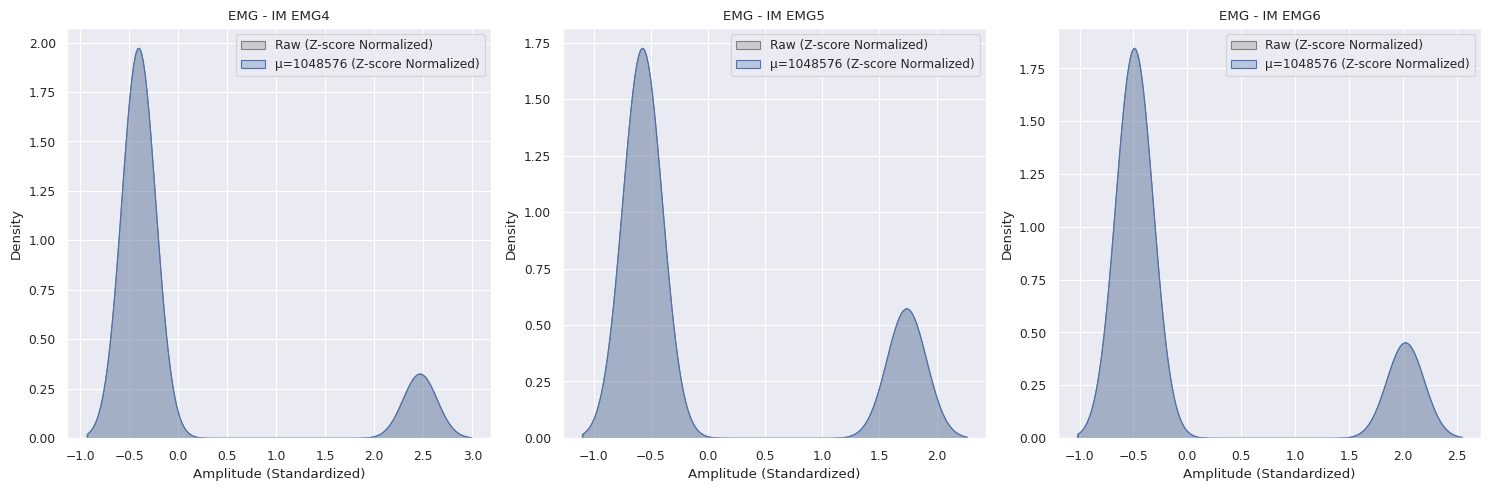

In [ ]:
# List to store normalized data for comparison
mu_values = [2**20]

print(emg.numpy().shape)

# Normalize EMG data with different μ values
normalized_emg_list = [mu_law_normalization(emg.numpy(), mu=mu) for mu in mu_values]

# Plot KDE for raw and μ-law normalized EMG data across the entire dataset using z-score normalization
print("Plotting KDE for raw and normalized EMG data (Z-score normalized)...")
plot_kde_comparison(normalized_emg_list, emg.numpy(), label="EMG", mu_values=mu_values, channel_names=config.channels_emg)